In [2]:
# Ignore warning
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import netCDF4
import h5py
import datetime as dt
import pyproj

import networkx as nx
import torch_geometric
from torch_geometric.utils.convert import to_networkx, from_networkx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

# check pytorch version
import torch    
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim    

from tqdm import tqdm

from pyproj import Proj, transform
from shapely.geometry import Polygon, Point, LineString, shape
import cartopy.crs as ccrs
import torch

import time

from scipy.interpolate import griddata

# import cdsapi
import xarray as xr
from urllib.request import urlopen

from urllib.request import urlretrieve

import pickle

import scipy.io as sio

%load_ext autoreload
%autoreload 2

import dgl
from dgl.data import DGLDataset
from dgl import save_graphs, load_graphs
import torch
import os

from functions import *
from DGL_model import *

## Updated version of data generation (Version 3; hope to be faster)

In [3]:
filename = "D:\\ISSM\\Helheim\\Helheim_r070.mat"
test = sio.loadmat(filename)

In [ ]:
test = sio.loadmat(filename)
rate = int(filename[-7:-4])*10

xc = test['S'][0][0][0]
yc = test['S'][0][0][1]
elements = test['S'][0][0][2]-1

smb = test['S'][0][0][3]
vx = test['S'][0][0][4]
vy = test['S'][0][0][5]
vel = test['S'][0][0][6]
surface = test['S'][0][0][7]
base = test['S'][0][0][8]
H = test['S'][0][0][9]
f = test['S'][0][0][10]

n_year, n_sample = H.shape

for t in tqdm(range(0, n_year)):
    # INPUT: x/y coordinates, melting rate, time, SMB, Vx0, Vy0, Surface0, Base0, Thickness0, Floating0
    inputs = torch.zeros([n_sample, 11])
    # OUTPUT: Vx, Vy, Vel, Surface, Thickness, Floating
    outputs = torch.zeros([n_sample, 6])
    
    ## INPUTS ================================================
    inputs[:, 0] = torch.tensor((xc[:, 0]-xc.min())/(xc.max()-xc.min())) # X coordinate
    inputs[:, 1] = torch.tensor((yc[:, 0]-yc.min())/(yc.max()-yc.min())) # Y coordinate
    inputs[:, 2] = torch.tensor(rate*0.001) # Melting rate
    inputs[:, 3] = torch.tensor(t/n_year) # Year
    inputs[:, 4] = torch.tensor(smb[t, :]) # Surface mass balance
    inputs[:, 5] = torch.tensor(vx[0, :]/5000) # Initial Vx
    inputs[:, 6] = torch.tensor(vy[0, :]/5000) # Initial Vx
    inputs[:, 7] = torch.tensor(surface[0, :]/4000) # Initial surface elevation
    inputs[:, 8] = torch.tensor(base[0, :]/4000) # Initial base elevation
    inputs[:, 9] = torch.tensor(H[0, :]/4000) # Initial ice thickness
    inputs[:, 10] = torch.tensor(f[0, :]/3000) # Initial floating part
    
    ## OUTPUTS ===============================================
    outputs[:, 0] = torch.tensor(vx[t, :]/5000) # Initial Vx
    outputs[:, 1] = torch.tensor(vy[t, :]/5000) # Initial Vx
    outputs[:, 2] = torch.tensor(vel[t, :]/5000) # Initial surface elevation
    outputs[:, 3] = torch.tensor(surface[t, :]/4000) # Initial base elevation
    outputs[:, 4] = torch.tensor(H[t, :]/4000) # Initial ice thickness
    outputs[:, 5] = torch.tensor(f[t, :]/3000) # Initial floating part

    # for i in range(0, n_sample):        
    #     inputs[i, :] = torch.tensor([(xc[i, 0]-xc.min())/(xc.max()-xc.min()), (yc[i, 0]-yc.min())/(yc.max()-yc.min()), rate*0.001, t/n_year, smb[t,i],
    #                                  vx[0, i]/5000, vy[0, i]/5000, surface[0, i]/4000, base[0,i]/4000, H[0,i]/4000, f[0,i]/3000
    #                                 ])
    #     outputs[i, :] = torch.tensor([vx[t, i]/5000, vy[t, i]/5000, vel[t,i]/5000, surface[t, i]/4000, H[t,i]/4000, f[t,i]/3000])

In [2]:
## MAKE TRAINING AND TESTING DATASETS FOR GNN
train_files = []
val_files = []
test_files = []

for f in glob.glob(f'D:\\ISSM\\Helheim\\Helheim_r*_030.mat'):
    if int(f[-11:-8]) <= 100 and f[-11:-8] != "080":
        train_files.append(f)
        if int(f[-11:-8])%10 == 0: # f[-11:-8] == "070" or f[-11:-8] == "080" or f[-11:-8] == "115" or f[-11:-8] == "115":
            val_files.append(f)
            test_files.append(f)
        # elif f[-11:-8] == "085" or f[-11:-8] == "105" or f[-11:-8] == "125":
        #     test_files.append(f)
        else:
            train_files.append(f)
        
print(train_files)
print(val_files)
print(test_files)
    
# train_set = GNN_Helheim_Dataset(train_files)
# save_graphs(f"D:\\ISSM\\Helheim\\DGL_Helheim_train_030.bin", train_set.graphs)

# val_set = GNN_Helheim_Dataset(val_files)
# save_graphs(f"D:\\ISSM\\Helheim\\DGL_Helheim_val_030.bin", val_set.graphs)

test_set = GNN_Helheim_Dataset(test_files)
# save_graphs(f"D:\\ISSM\\Helheim\\DGL_Helheim_test_030.bin", test_set.graphs)

print("Done!")

['D:\\ISSM\\Helheim\\Helheim_r070_030.mat', 'D:\\ISSM\\Helheim\\Helheim_r075_030.mat', 'D:\\ISSM\\Helheim\\Helheim_r075_030.mat', 'D:\\ISSM\\Helheim\\Helheim_r085_030.mat', 'D:\\ISSM\\Helheim\\Helheim_r085_030.mat', 'D:\\ISSM\\Helheim\\Helheim_r090_030.mat', 'D:\\ISSM\\Helheim\\Helheim_r095_030.mat', 'D:\\ISSM\\Helheim\\Helheim_r095_030.mat', 'D:\\ISSM\\Helheim\\Helheim_r100_030.mat']
['D:\\ISSM\\Helheim\\Helheim_r070_030.mat', 'D:\\ISSM\\Helheim\\Helheim_r090_030.mat', 'D:\\ISSM\\Helheim\\Helheim_r100_030.mat']
['D:\\ISSM\\Helheim\\Helheim_r070_030.mat', 'D:\\ISSM\\Helheim\\Helheim_r090_030.mat', 'D:\\ISSM\\Helheim\\Helheim_r100_030.mat']


100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:34<00:00, 11.55s/it]

Done!


In [3]:
g = test_set[0]

In [5]:
torch.cat([g.edges()[0][None, :], g.edges()[1][None, :]], axis = 0).shape

torch.Size([2, 139798])

In [103]:
torch.arctan(edge_attr)

tensor([[0.1658, 0.0779, 0.0837, 0.0058],
        [0.0950, 0.0409, 0.0647, 0.0239],
        [0.0984, 0.0314, 0.0207, 0.0107],
        ...,
        [0.2540, 0.0588, 0.0542, 0.0047],
        [0.4109, 0.0632, 0.0567, 0.0066],
        [0.2340, 0.0286, 0.0337, 0.0051]])

In [113]:
# edge_index = torch.cat([g.edges()[0][None, :], g.edges()[1][None, :]], axis = 0).type(torch.int64)

in_feat = g.ndata['feat'][:, :]
edge_index = torch.cat([g.edges()[0][None, :], g.edges()[1][None, :]], axis = 0).type(torch.int64)
coords_curr = g.ndata['feat'][:, :2].detach().clone()
edge_attr = g.edata['slope'][:, :, 0].type(torch.float32)


In [118]:
x = in_feat
row, col = edge_index
# agg = unsorted_segment_sum(edge_attr, row, num_segments=x.size(0))
agg = unsorted_segment_mean(edge_attr, row, num_segments=x.size(0))

agg = agg + torch.mm(x, self.root)

out = nn.Tanh(agg) / 4

# if self.residual:
#     out = x + out

NameError: name 'self' is not defined

In [127]:
agg = unsorted_segment_mean(edge_attr, row, num_segments=coords_curr.size(0))
agg

tensor([[0.1092, 0.0380, 0.0434, 0.0116],
        [0.1765, 0.0070, 0.0496, 0.0516],
        [0.1092, 0.0032, 0.1322, 0.1354],
        ...,
        [0.4208, 0.0442, 0.0477, 0.0065],
        [0.3669, 0.0410, 0.0397, 0.0046],
        [0.2565, 0.0790, 0.0787, 0.0054]])

In [123]:
in_feat.size(0)

23466

In [90]:
g.edata['weight'].shape

torch.Size([139798, 1])

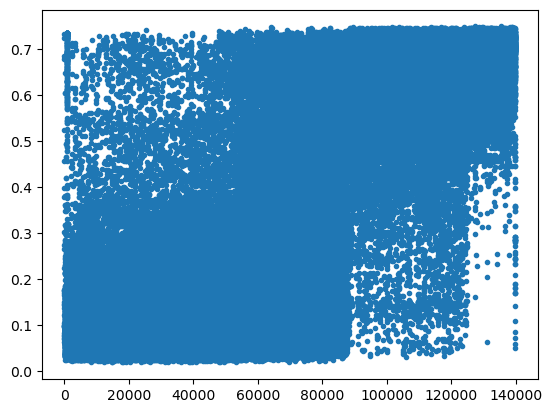

In [107]:
plt.plot(torch.arctan(edge_attr[:, 0]), '.')

In [111]:
coords_curr = g.ndata['feat'][:, :2].detach().clone()

In [112]:
coords_curr.shape

torch.Size([23466, 2])

In [69]:
edge_attr.dtype

torch.float32

In [70]:
in_feat.dtype

torch.float32

In [ ]:
edge_index

In [60]:
edge_attr.shape

torch.Size([278604, 2])

In [51]:
edge_index = torch.cat([g.edges()[0], g.edges()[0]], axis = 0)
edge_index.shape

torch.Size([557208])

In [48]:
edge_index.shape

torch.Size([557208])

In [131]:
node_feat = g.ndata['feat'][:, 2:]
coords_curr = g.ndata['feat'][:, :2].detach().clone()
g.ndata['h'] = node_feat
# coordinate feature
g.ndata['x'] = coords_curr
# edge feature
# if self.edge_feat_size > 0:
#     assert edge_feat is not None, "Edge features must be provided."
#     graph.edata['a'] = edge_feat
# get coordinate diff & radial features
g.apply_edges(fn.u_sub_v('x', 'x', 'x_diff'))

In [135]:
g.edata['x_diff'].shape

torch.Size([139798, 2])

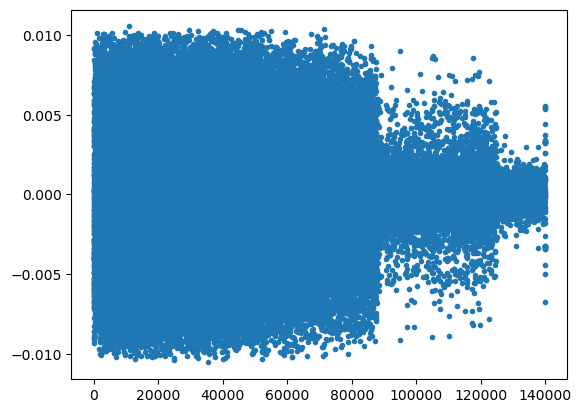

In [138]:
plt.plot(g.edata['x_diff'][:, 1], '.')

In [30]:
g.edata['weight'][:, 0]

tensor([0.1674, 0.0953, 0.0987,  ..., 0.4357, 0.1103, 0.2383],
       dtype=torch.float64)

In [25]:
test_set[0].ndata['feat'][:, :2].detach().clone()

tensor([[0.7485, 0.1728],
        [0.7602, 0.1499],
        [0.7580, 0.1366],
        ...,
        [0.9583, 0.4028],
        [0.9571, 0.4046],
        [0.9544, 0.4056]])

In [23]:
edge_index = torch.zeros(2, len(test_set[0].edges()[0]))
edge_index[0] = test_set[0].edges()[0]
edge_index[1] = test_set[0].edges()[1]

(tensor([    0,     0,     0,  ..., 23465, 23465, 23465]),
 tensor([ 7087,   329, 10399,  ..., 23464, 11032,    98]))

In [24]:
edge_index

tensor([[    0.,     0.,     0.,  ..., 23465., 23465., 23465.],
        [ 7087.,   329., 10399.,  ..., 23464., 11032.,    98.]])

In [7]:
h, edge_index, edge_attr, coords_curr = data.x, data.edge_index, data.edge_attr, \
                                        data.coords_init.detach().clone()

AttributeError: 'DGLGraph' object has no attribute 'edge_index'

In [24]:
from dgl.data import split_dataset
from dgl.dataloading import GraphDataLoader

def get_dataloaders(dataset, seed, batch_size=32, shuffle = False):
    # Use a 80:10:10 train-val-test split
    train_set, val_set, test_set = split_dataset(dataset,
                                                 frac_list=[0.6, 0.39, 0.01],
                                                 shuffle=True,
                                                 random_state=seed)
    train_loader = GraphDataLoader(train_set, use_ddp=True, batch_size=batch_size, shuffle=shuffle)
    val_loader = GraphDataLoader(val_set, use_ddp=False, batch_size=batch_size, shuffle=shuffle)
    # test_loader = GraphDataLoader(test_set, batch_size=batch_size)

    return train_loader, val_loader #, test_loader

In [33]:
train_set1, val_set1, test_set1 = split_dataset(train_set,
                                             frac_list=[0.6, 0.4, 0.0],
                                             shuffle=True,
                                             random_state=1)

In [34]:
len(train_set1), len(val_set1)

(1409, 939)

In [35]:
len(train_set)

2349

In [25]:
train_loader, val_loader = get_dataloaders(train_set, 1, 16, True)

In [27]:
len(val_loader)

58

In [234]:
test_set = GNN_Helheim_Dataset(test_files)

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:28<00:00, 14.25s/it]


In [5]:
i = 0
mask = np.where(test['S'][0][0][11][0] > -100000)[0]
test_set[i].ndata['label'][mask, :].shape

torch.Size([15027, 6])

In [6]:
for i in range(0, 16):
    if i == 0:
        mask_batch = mask
    else:
        mask_batch = np.append(mask_batch, mask+i*mask.shape[0])

In [110]:
coords_curr = g.ndata['feat'][:, :2].detach().clone()

NameError: name 'coord_curr' is not defined

In [ ]:
del mask

tensor([0.3500, 0.3500, 0.3500,  ..., 0.3500, 0.3500, 0.3500]) tensor([0.7663, 0.7663, 0.7663,  ..., 0.7663, 0.7663, 0.7663])


tensor(-2184.2417)

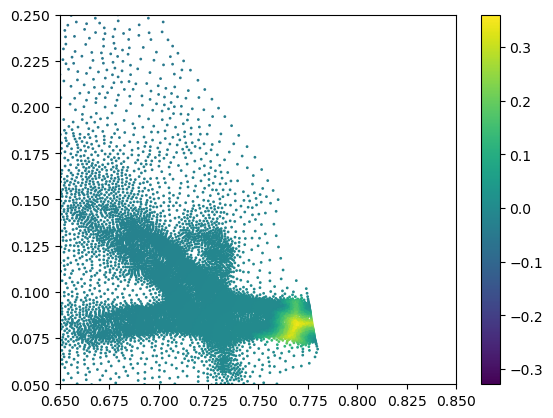

In [203]:
i = 200
print(test_set[i].ndata['feat'][:, 2], test_set[i].ndata['feat'][:, 3])
plt.scatter(test_set[i].ndata['feat'][:, 0], test_set[i].ndata['feat'][:, 1], c= test_set[i].ndata['label'][:, 5], s = 1)
plt.xlim(0.65, 0.85)
plt.ylim(0.05, 0.25)
plt.colorbar()
train_set[i].ndata['label'][:, 5].min()

In [3]:
filename = 'D:\\ISSM\\Helheim\\Helheim_r070_030.mat'
rate = int(filename[-11:-8])*10
test = sio.loadmat(filename)

xc = test['S'][0][0][0]
yc = test['S'][0][0][1]
elements = test['S'][0][0][2]-1
smb = test['S'][0][0][3]
vx = test['S'][0][0][4]
vy = test['S'][0][0][5]
vel = test['S'][0][0][6]
surface = test['S'][0][0][7]
base = test['S'][0][0][8]
H = test['S'][0][0][9]
f = test['S'][0][0][10]
mask = test['S'][0][0][11]

In [9]:
train_set[0].ndata['feat'].shape

torch.Size([23466, 12])

In [196]:
ice = np.where(mask < 0, mask / 600000, mask/6000)

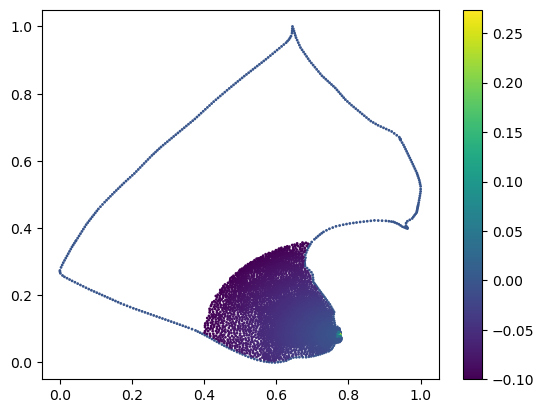

In [17]:
mask = torch.where((train_set[0].ndata['label'][:, -1] > -0.1))[0]
plt.scatter(train_set[0].ndata['feat'][mask, 0], train_set[0].ndata['feat'][mask, 1], c= train_set[0].ndata['label'][mask, 5], s = 1, vmin = -0.1)
plt.colorbar()
# plt.xlim(0.65, 0.85)
# plt.ylim(0.05, 0.25)

In [22]:
glob.glob(f'D:\\ISSM\\Helheim\\Helheim_r*_030.mat')[0][-11:-8]

'070'

In [11]:
mesh = 100
f"../data/DGL_train_dataset_v3_m{mesh:05d}.bin"

'../data/DGL_train_dataset_v3_m00100.bin'

In [17]:
save_graphs("../data/DGL_train_dataset_g5000.bin", train_set.graphs)

In [18]:
save_graphs("../data/DGL_val_dataset_g5000.bin", val_set.graphs)

In [19]:
save_graphs("../data/DGL_test_dataset_g5000.bin", test_set.graphs)

In [3]:
from dgl import save_graphs, load_graphs

class ISSM_train_dataset(DGLDataset):
    def __init__(self):
        super().__init__(name='pig')
        
    def process(self):
        glist, _ = load_graphs("../data/DGL_train_dataset.bin")
        self.graphs = glist
        
    def __getitem__(self, i):
        return self.graphs[i]
    
    def __len__(self):
        return len(self.graphs)
    
class ISSM_test_dataset(DGLDataset):
    def __init__(self):
        super().__init__(name='pig')
        
    def process(self):
        glist, _ = load_graphs("../data/DGL_test_dataset_g10000.bin")
        self.graphs = glist
        
    def __getitem__(self, i):
        return self.graphs[i]
    
    def __len__(self):
        return len(self.graphs)

In [4]:
train_set = ISSM_train_dataset()

In [9]:
a = train_set[0].ndata['feat'][:, :-1]

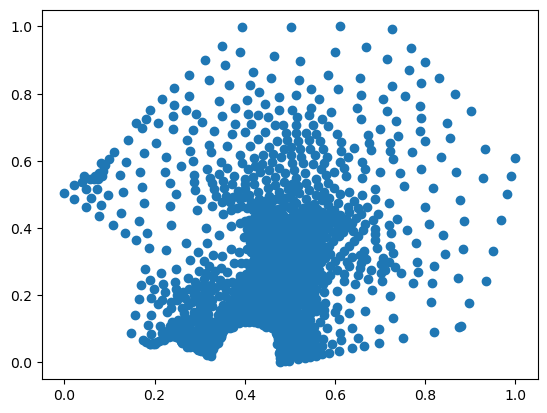

In [12]:
plt.scatter(a[:, 0], a[:, 1])

In [283]:
test_set = ISSM_test_dataset()

## CNN (old version)

In [23]:
# GRID FILTERING ==========================================================================

xext = [xc.min(), xc.max()]
yext = [yc.min(), yc.max()]
res = 1000

gridx, gridy = np.meshgrid(np.arange(xext[0], xext[1], res), np.arange(yext[0], yext[1], res))
coord = (xc[:, 0], yc[:, 0]) #np.array([xc[:, 0], yc[:, 0]]).transpose()

# Read boundary matrix
test = sio.loadmat("D:\\ISSM\\Helheim\\Helheim_boundary.mat")
boundary = test['boundary']
bind = np.where(boundary == 1)[0]

df = pd.DataFrame()
points = []

for i, ind in enumerate(bind):
    points.append((xc[ind][0], yc[ind][0]))
    df.loc[i, "X"] = xc[ind][0]
    df.loc[i, "Y"] = yc[ind][0]

xn, yn = sort_xy(df["X"].values, df["Y"].values)
df1 = pd.DataFrame({'X': xn, 'Y': yn})   


geometry = [Point(xy) for xy in zip(df1.X, df1.Y)]
gdf = geopandas.GeoDataFrame(df1, geometry=geometry)

# Polygon of Helheim Glacier
gdf['shape_id'] = 0
polygon = gdf.groupby('shape_id')['geometry'].apply(lambda x: Polygon(x.tolist())).reset_index()

grid = []
grid_i = []
grid_j = []

for i in range(0, gridx.shape[0]):
    for j in range(0, gridx.shape[1]):
        grid.append(Point(gridx[i, j], gridy[i, j]))
        grid_i.append(i)
        grid_j.append(j)

gridf = geopandas.GeoDataFrame(pd.DataFrame({'ind_i': grid_i, 'ind_j': grid_j}), geometry=grid)

pointInPoly = geopandas.sjoin(gridf, polygon, op='within') 

grid_valid = gridx.copy() * np.nan
grid_valid[pointInPoly['ind_i'].values, pointInPoly['ind_j'].values] = 1
print("Polygon prepared!")
# =========================================================================================

496
Polygon prepared!


In [ ]:
xext = [xc.min(), xc.max()]
yext = [yc.min(), yc.max()]
res = 1000

gridx, gridy = np.meshgrid(np.arange(xext[0], xext[1], res), np.arange(yext[0], yext[1], res))
coord = (xc[:, 0], yc[:, 0]) #np.array([xc[:, 0], yc[:, 0]]).transpose()

In [3]:
with open(f'D:\\ISSM\\Helheim\\valid_grid200_14297.pkl', 'rb') as file:
    grid_valid = pickle.load(file)

In [30]:
## Dataset for train ===================================

from scipy.interpolate import griddata

folder = "D:\\ISSM\\Helheim"
files = glob.glob(f"{folder}\\Helheim_*_030.mat")

for i, filename in enumerate(files[:]):
    
    dataset = GNN_Helheim_Dataset(files[i:i+1])
    
    print(filename)
    rate = int(filename.split("_r")[1][:3])
    test = sio.loadmat(filename)

    xc = test['S'][0][0][0]
    yc = test['S'][0][0][1]
    elements = test['S'][0][0][2]-1

    H = test['S'][0][0][9]

    n_year, n_sample = H.shape
    
    input0 = np.zeros((n_year, dataset[0].ndata['feat'].shape[1], gridx.shape[0], gridx.shape[1]))
    output0 = np.zeros((n_year, dataset[0].ndata['label'].shape[1], gridx.shape[0], gridx.shape[1])) 

    for t in tqdm(range(0, n_year)):
        
        inputs = dataset[t].ndata['feat']
        outputs = dataset[t].ndata['label']

        for c in range(0, inputs.shape[1]):
            input0[t, c, :, :] = griddata(coord, inputs[:, c], (gridx, gridy), method='nearest')
        for c in range(0, outputs.shape[1]):
            output0[t, c, :, :] = griddata(coord, outputs[:, c], (gridx, gridy), method='nearest')
    
    input0 = input0 * grid_valid
    output0 = output0 * grid_valid
    with open(filename.replace(".mat", "_CNN_v2.pkl"), 'wb') as file:
        pickle.dump([input0.astype(np.float16), output0.astype(np.float16)], file)

100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.65s/it]


D:\ISSM\Helheim\Helheim_r070_030.mat


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.72s/it]


D:\ISSM\Helheim\Helheim_r075_030.mat


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:28<00:00, 28.75s/it]


D:\ISSM\Helheim\Helheim_r080_030.mat


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.03s/it]


D:\ISSM\Helheim\Helheim_r085_030.mat


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.51s/it]


D:\ISSM\Helheim\Helheim_r090_030.mat


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.36s/it]


D:\ISSM\Helheim\Helheim_r095_030.mat


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.28s/it]


D:\ISSM\Helheim\Helheim_r100_030.mat


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.22s/it]


D:\ISSM\Helheim\Helheim_r105_030.mat


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.82s/it]


D:\ISSM\Helheim\Helheim_r110_030.mat


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:28<00:00, 28.82s/it]


D:\ISSM\Helheim\Helheim_r115_030.mat


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.85s/it]


D:\ISSM\Helheim\Helheim_r120_030.mat


100%|███████████████████████████████████████████████████████████████████████████| 261/261 [16:03<00:00,  3.69s/it]


## CNN (new version)

In [11]:
filename = f'D:\\ISSM\\Helheim\\Helheim_r100_030.mat'
    
rate = int(filename[-11:-8])

test = sio.loadmat(filename)

xc = test['S'][0][0][0]
yc = test['S'][0][0][1]
elements = test['S'][0][0][2]-1
vel = test['S'][0][0][6][:, idx]
idx = np.where((xc[:, 0]>230000) & (yc[:, 0] < -2500000))[0] # Spatial filtering
xc = xc[idx]
yc = yc[idx]

In [10]:
xext = [xc.min(), xc.max()]
yext = [yc.min(), yc.max()]
res = 200

gridx, gridy = np.meshgrid(np.arange(xext[0]+res, xext[1]-res, res), np.arange(yext[0]+res, yext[1]-res, res))
coord = (xc[:, 0], yc[:, 0]) #np.array([xc[:, 0], yc[:, 0]]).transpose()

print(gridx.shape)

(541, 425)


In [3]:
with open(f'D:\\ISSM\\Helheim\\valid_grid200_14297.pkl', 'rb') as file:
    grid_valid = pickle.load(file)

In [28]:
## Dataset for train ===================================

from scipy.interpolate import griddata

folder = "D:\\ISSM\\Helheim"
files = glob.glob(f"{folder}\\Helheim_*_030.mat")

for i, filename in enumerate(files[:]):
    
    dataset = GNN_Helheim_Dataset(files[i:i+1])
    
    print(filename)
    # rate = int(filename.split("_r")[1][:3])
    # test = sio.loadmat(filename)

    # xc = test['S'][0][0][0]
    # yc = test['S'][0][0][1]
    # elements = test['S'][0][0][2]-1

    # H = test['S'][0][0][9]

    n_year = len(dataset) #, n_sample = H.shape
    n_samples = dataset[0].num_nodes()
    
    input0 = np.zeros((n_year, dataset[0].ndata['feat'].shape[1], gridx.shape[0], gridx.shape[1]))
    output0 = np.zeros((n_year, dataset[0].ndata['label'].shape[1], gridx.shape[0], gridx.shape[1])) 

    for t in tqdm(range(0, n_year)):
        
        inputs = dataset[t].ndata['feat']
        outputs = dataset[t].ndata['label']

        for c in range(0, inputs.shape[1]):
            input0[t, c, :, :] = griddata(coord, inputs[:, c], (gridx, gridy), method='nearest')
        for c in range(0, outputs.shape[1]):
            output0[t, c, :, :] = griddata(coord, outputs[:, c], (gridx, gridy), method='nearest')
    
    input0 = input0 * grid_valid
    output0 = output0 * grid_valid
    with open(filename.replace(".mat", f"_CNN_{int(res)}m.pkl"), 'wb') as file:
        pickle.dump([input0.astype(np.float16), output0.astype(np.float16)], file)

100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.26s/it]


D:\ISSM\Helheim\Helheim_r065_030.mat


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:22<00:00, 22.26s/it]


D:\ISSM\Helheim\Helheim_r070_030.mat


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.36s/it]


D:\ISSM\Helheim\Helheim_r075_030.mat


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.52s/it]


D:\ISSM\Helheim\Helheim_r080_030.mat


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:22<00:00, 22.25s/it]


D:\ISSM\Helheim\Helheim_r085_030.mat


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.60s/it]


D:\ISSM\Helheim\Helheim_r090_030.mat


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.61s/it]


D:\ISSM\Helheim\Helheim_r095_030.mat


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.33s/it]


D:\ISSM\Helheim\Helheim_r100_030.mat


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:26<00:00, 26.78s/it]


D:\ISSM\Helheim\Helheim_r105_030.mat


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:45<00:00, 45.35s/it]


D:\ISSM\Helheim\Helheim_r110_030.mat


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:26<00:00, 26.21s/it]


D:\ISSM\Helheim\Helheim_r115_030.mat


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.63s/it]


D:\ISSM\Helheim\Helheim_r120_030.mat


100%|█████████████████████████████████████████████████████████████████████████████| 260/260 [18:20<00:00,  4.23s/it]


In [28]:
input0 = dataset[t].ndata['feat'].detach().numpy()
output0 = dataset[t].ndata['label'].detach().numpy()

for c in range(0, inputs.shape[1]):
    input0[t, c, :, :] = griddata(coord, inputs[:, c], (gridx, gridy), method='nearest')
for c in range(0, outputs.shape[1]):
    output0[t, c, :, :] = griddata(coord, outputs[:, c], (gridx, gridy), method='nearest')

IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

In [304]:
for grid in [10000]:
    filename = f'D:\\ISSM\\version2\\transient_g{grid}_y20_r*.mat'
    files = glob.glob(filename)
    first = True

    for filename in files[:1]:
        print(filename)

        rate = float(filename[-7:-4])

        test = sio.loadmat(filename)

        xc = test['S'][0][0][0]
        yc = test['S'][0][0][1]
        # Interpolate points to images
        gridx, gridy = np.meshgrid(np.arange(xc.min(), xc.max(), 2000), np.arange(yc.min(), yc.max(), 2000))
        coord = np.array([xc[:, 0], yc[:, 0]]).transpose()
        elements = test['S'][0][0][2]-1

        smb = test['S'][0][0][3]
        vx = test['S'][0][0][4]
        vy = test['S'][0][0][5]
        vel = test['S'][0][0][6]
        H = test['S'][0][0][7]
        f = test['S'][0][0][8]

        n_year, n_sample = H.shape    

        input0 = np.zeros((n_year, 5, gridx.shape[0], gridx.shape[1]))
        output0 = np.zeros((n_year, 5, gridx.shape[0], gridx.shape[1]))

        if (rate % 200 != 0) and (rate % 200 != 100):
            train_index0 = np.ones(n_year)*0
        elif rate % 200 == 100:
            train_index0 = np.ones(n_year)*1
        elif rate % 200 == 0:
            train_index0 = np.ones(n_year)*2        

        for t in tqdm(range(0, n_year)):

            inputs = torch.zeros([n_sample, 5])
            outputs = torch.zeros([n_sample, 5])

            for i in range(0, n_sample):        
                inputs[i, :] = torch.tensor([(xc[i, 0]-xc.min())/(xc.max()-xc.min()), (yc[i, 0]-yc.min())/(yc.max()-yc.min()), rate*0.001, t/n_year, smb[t,i]])
                outputs[i, :] = torch.tensor([vx[t, i]/5000, vy[t, i]/5000, vel[t,i]/5000, H[t,i]/4000, f[t,i]/3000])

            for c in range(0, inputs.shape[1]):

                input0[t, c, :, :] = griddata(coord, inputs[:, c], (gridx, gridy), method='linear')
                output0[t, c, :, :] = griddata(coord, outputs[:, c], (gridx, gridy), method='linear')

        if first:
            arr_input = input0.astype(np.float16)
            arr_output = output0.astype(np.float16)
            train_index = train_index0.astype(np.float16)
            first = False
        else:
            arr_input = np.append(arr_input.astype(np.float16), input0, axis = 0)
            arr_output = np.append(arr_output.astype(np.float16), output0, axis = 0)
            train_index = np.append(train_index.astype(np.float16), train_index0)

    # with open(f'../data/CNN_dataset_g{grid}.pkl', 'wb') as file:
    #     pickle.dump([arr_input.astype(np.float16), arr_output.astype(np.float16), train_index.astype(np.float16)], file)

D:\ISSM\version2\transient_g10000_y20_r000.mat


100%|█████████████████████████████████████████████████████████████████████████| 240/240 [13:49<00:00,  3.46s/it]


In [29]:
with open(f'../data/CNN_dataset_g10000.pkl', 'wb') as file:
    pickle.dump([arr_input.astype(np.float16), arr_output.astype(np.float16), train_index.astype(np.float16)], file)

In [21]:
arr_input = np.append(arr_input, input0, axis = 0)
arr_output = np.append(arr_output, output0, axis = 0)

In [52]:
with open(f'../data/CNN_dataset_g10000.pkl', 'rb') as file:
    [arr_input, arr_output, train_index] = pickle.load(file)   

In [112]:
from torch.utils.data import TensorDataset, DataLoader, Dataset

class CNN_Dataset(Dataset):
    def __init__(self, input_grid, output_graph):
        # store the image and mask filepaths, and augmentation
        # transforms
        self.input = input_grid
        self.output = output_graph
        
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.output)
    def __getitem__(self, n):

        cnn_input = torch.tensor(self.input[n], dtype=torch.float32)
        cnn_input[torch.isnan(cnn_input)] = 0
        
        cnn_output = self.output[n].ndata['label']
        # cnn_output = torch.transpose(cnn_output, 0, 1)
                        
        return (cnn_input, cnn_output)

In [118]:
len(train_graphs)

2

In [280]:
mesh = 10000

train_graphs = load_graphs(f"../data/DGL_train_dataset_g{mesh}.bin")[0]
val_graphs = load_graphs(f"../data/DGL_val_dataset_g{mesh}.bin")[0]
test_graphs = load_graphs(f"../data/DGL_test_dataset_g{mesh}.bin")[0]

with open(f'../data/CNN_dataset_g{mesh}.pkl', 'rb') as file:
    [grid_input, grid_output, train_index] = pickle.load(file)

_, _, nrow, ncol = grid_input.shape
train_grid = grid_input[train_index == 0]
val_grid = grid_input[train_index == 1]
test_grid = grid_input[train_index == 2]


In [246]:
mask = torch.isnan(torch.tensor(train_grid[0, 0]))

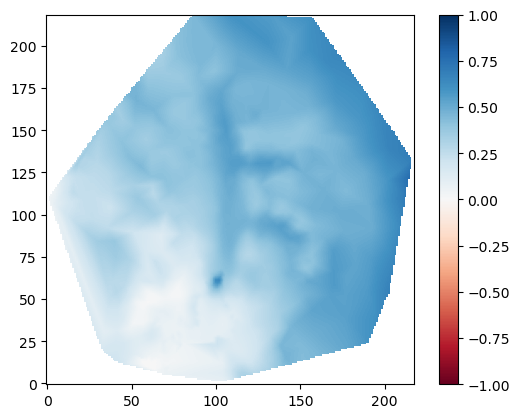

In [297]:
plt.imshow(grid_output[240*10-0, 3], origin = "lower", vmin = -1, vmax = 1, cmap = "RdBu")
plt.colorbar()

In [234]:
n_nodes = sampling.shape[0]
n_samples = data.shape[0]
out = torch.zeros([n_samples, n_nodes, 5]).cuda()

In [235]:
out
for i in range(0, n_nodes):
    out[:, i, :] = data[:, :, sampling[i][0], sampling[i][1]]

In [223]:
sampling = torch.zeros(xy.shape, dtype=torch.int)
xy_grid = torch.tensor(train_grid[0, 0:2], dtype=torch.float32)
xy_grid[torch.isnan(xy_grid)] = -1

for i in range(0, xy.shape[0]):
    distance = (xy_grid[0]-xy[i,0])**2 + (xy_grid[1]-xy[i,1])**2
    k = torch.where(distance == torch.min(distance))
    sampling[i, 0] = k[0].item()
    sampling[i, 1] = k[1].item()

In [226]:
sampling[100]

tensor([  7, 127], dtype=torch.int32)

In [211]:
xy_grid[][sampling_idx[0][1], sampling_idx[0][1]]

tensor(0.1935)

In [206]:
sampling_idx[0]

tensor([12, 42], dtype=torch.int32)

In [174]:
torch.min((xy_grid[0]-xy[i,0])**2 + (xy_grid[1]-xy[i,1])**2)

tensor(4.3004e-06)

In [185]:
k[0].item()

15

In [169]:
(xy_grid[0]-xy[i,0])**2 + (xy_grid[1]-xy[i,1])**2

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])

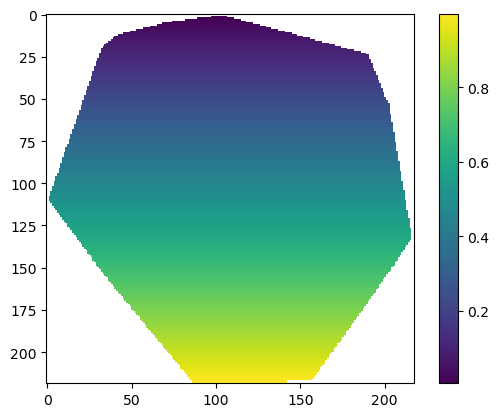

In [166]:
plt.imshow(xy_grid[1])
plt.colorbar()

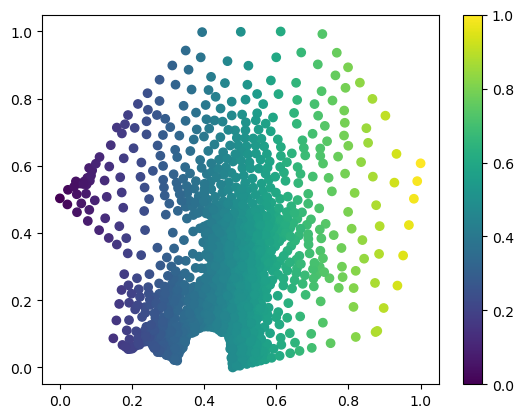

In [242]:
plt.scatter(xy[:, 0], xy[:, 1], c = xy[:, 0])
plt.colorbar()

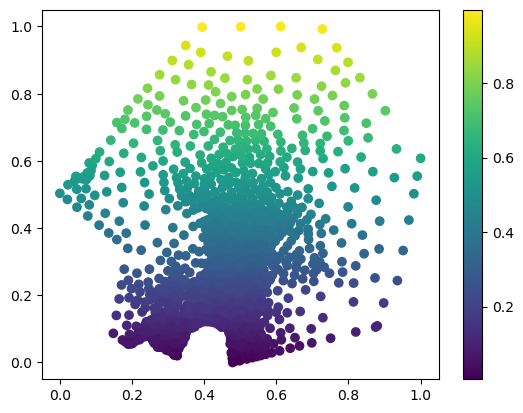

In [253]:
plt.scatter(xy[:, 0], xy[:, 1], c = np.array(out[0, :, 1].cpu()))
plt.colorbar()

In [156]:
train_grid[0, 0:2].shape

(2, 219, 218)

In [126]:

train_dataset = CNN_Dataset(train_grid, train_graphs)
val_dataset = CNN_Dataset(val_grid, val_graphs)
test_dataset = CNN_Dataset(test_grid, test_graphs)

In [133]:
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler

In [138]:
train_sampler = DistributedSampler(
    train_dataset,
    num_replicas=1,
    rank=0,
    shuffle=True
)
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    sampler=train_sampler
)

In [228]:
for (data, target) in train_loader:
    pass

In [146]:
train_loader = DataLoader()

torch.Size([5, 219, 218])

In [230]:
data.shape, target.shape

(torch.Size([16, 5, 219, 218]), torch.Size([16, 1112, 5]))

In [32]:
mesh = 10000
glist, _ = load_graphs(f"../data/DGL_train_dataset_g{mesh}.bin")

In [45]:
first = True
for bg in glist:
    lb0 = bg.ndata['feat']
    lb0 = lb0[None, :]
    if first:
        lb = lb0
        first = False
    else:
        lb = torch.cat([lb, lb0], dim = 0)
    

In [99]:
class CNN(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_nodes, nrow, ncol, n_filters=128, kernel = 5):
        super().__init__()
        self.activation = nn.LeakyReLU()
        self.n_nodes = n_nodes
        self.n_outputs = n_outputs
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(n_inputs, n_filters, kernel, padding = "same"),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )        
        self.conv2 = nn.Sequential(
            nn.Conv2d(n_filters, n_filters, kernel, padding = "same"),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )        
        self.conv3 = nn.Sequential(
            nn.Conv2d(n_filters, n_filters, kernel, padding = "same"),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(n_filters, n_filters, kernel, padding = "same"),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(n_filters, n_filters, kernel, padding = "same"),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )     
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=int(n_filters*(nrow//(2**5))*(ncol//(2**5))), out_features=n_outputs * n_nodes)


    def forward(self, x):
        
        x = self.activation(self.conv1(x))
        print(x.shape)
        x = self.activation(self.conv2(x))
        print(x.shape)
        x = self.activation(self.conv3(x))
        print(x.shape)
        x = self.activation(self.conv4(x))
        print(x.shape)
        x = self.activation(self.conv5(x))
        print(x.shape)
        x = self.flatten(x)
        x = self.fc1(x)
        x = x.reshape(-1, self.n_nodes, self.n_outputs)
        
        return x

In [100]:
x0 = torch.tensor(arr_input[:2], dtype=torch.float32)
x0[torch.isnan(x0)] = 0
x0.shape

torch.Size([2, 5, 219, 218])

In [101]:
model = CNN(5, 3, 1112, 219, 218)

In [102]:
a = model(x0)

torch.Size([2, 128, 109, 109])
torch.Size([2, 128, 54, 54])
torch.Size([2, 128, 27, 27])
torch.Size([2, 128, 13, 13])
torch.Size([2, 128, 6, 6])


In [103]:
a.shape

torch.Size([2, 1112, 3])

In [50]:
x = bg.ndata['label']
x1 = torch.transpose(x, 0, 1)

In [95]:
x.shape

torch.Size([1112, 5])

In [133]:
# Variable: Path to .exp file
text = "D:\\ISSM\\DomainOutline.exp"

# Process: Open .exp file for reading
file = open(text, 'r')

# Process: Read first line of .exp file
line = file.readline()
print(line)
# # Process: Decode line
# .exp = line.decode('utf-16', 'ignore')

# # Message: Return message to display
# print exp

# Process: Close file object
file.close()



## Name:



In [134]:
with open(text, 'r') as f:
    t = f.readlines()

df = pd.DataFrame()

for i, x in enumerate(t[5:-1]):
    
    df.loc[i, "X"] = float(x.split()[0])
    df.loc[i, "Y"] = float(x.split()[1])
    # print(x)

In [135]:
from shapely.geometry import Point, LineString, shape

#zip the coordinates into a point object and convert to a GeoData Frame
geometry = [Point(xy) for xy in zip(df.X, df.Y)]
gdf = geopandas.GeoDataFrame(df, geometry=geometry)


In [136]:
## Create outside cilp polygon
from shapely.geometry import box

gdf['shape_id'] = 0
polygon = gdf.groupby('shape_id')['geometry'].apply(lambda x: Polygon(x.tolist())).reset_index()

outpolygon = geopandas.GeoSeries(
    [
        box(*box(*polygon.total_bounds).buffer(2000).bounds).difference(
            polygon["geometry"].values[0]
        )
    ],
    crs=polygon.crs,
)

In [99]:
ds[0].ndata['train_mask']

tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)

In [100]:
from dgl.data import split_dataset
from dgl.dataloading import GraphDataLoader

def get_dataloaders(dataset, seed, batch_size=32):
    # Use a 80:10:10 train-val-test split
    train_set, val_set, test_set = split_dataset(dataset,
                                                 frac_list=[0.8, 0.1, 0.1],
                                                 shuffle=True,
                                                 random_state=seed)
    train_loader = GraphDataLoader(train_set, use_ddp=True, batch_size=batch_size, shuffle=True)
    val_loader = GraphDataLoader(val_set, batch_size=batch_size)
    test_loader = GraphDataLoader(test_set, batch_size=batch_size)

    return train_loader, val_loader, test_loader

In [117]:
train_loader

8640

In [118]:
loader = GraphDataLoader(ds, batch_size=len(ds), shuffle=True)

In [121]:
for bg in loader:
    b = bg.ndata['feat']

In [180]:
model = MLP(4, 6, 128)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

model = GCN(4, 6, 128)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

model = GIN(4, 6, 128)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

50950
50950
50950


In [235]:
from dgl.nn import EGNNConv

g = dgl.graph(([0,1,2,3,2,5,4,3], [1,2,3,4,0,3,1,3]))
node_feat, coord_feat, edge_feat = torch.rand(6, 10), torch.rand(6, 2), torch.rand(8, 2)
model = EGNNConv(10, 10, 10, 2)
# EGNNConv(in_size, hidden_size, out_size, edge_feat_size=0)
h, x = model(g, node_feat, coord_feat, edge_feat)

In [276]:
import dgl
import numpy as np
from dgl.nn import GATConv

# Case 1: Homogeneous graph

g = dgl.graph(([0,1,2,3,2,5], [1,2,3,4,0,3]))
g = dgl.add_self_loop(g)
feat = torch.ones((6, 10))
gatconv = GATConv(10, 2, num_heads=3)
res = gatconv(g, feat)
res.shape

torch.Size([6, 3, 2])

In [279]:
torch.mean(res, dim = 1).shape

torch.Size([6, 2])

In [243]:
node_feat = bg.ndata['feat']
print(node_feat.shape, node_feat.dtype)
coord_feat = bg.ndata['feat'][:, :2]
print(coord_feat.shape, coord_feat.dtype)
edge_feat = bg.edata['weight'].float() #.repeat(1, 2)
print(edge_feat.shape, edge_feat.dtype)

torch.Size([17792, 4]) torch.float32
torch.Size([17792, 2]) torch.float32
torch.Size([200160, 1]) torch.float32


In [245]:
model = EGNNConv(4, 128, 6, 1)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

52358


In [241]:
edge_feat.dtype

torch.float32

In [246]:
h, x = model(bg, node_feat, coord_feat, edge_feat)

In [247]:
h.shape

torch.Size([17792, 6])

In [256]:
pred = torch.cat([node_feat, coord_feat], dim=1)
pred.shape

torch.Size([17792, 6])

In [254]:
fn.copy_e

<function dgl.function.message.copy_e(e, out)>

In [192]:
bg.edata['weight']

tensor([[0.0145],
        [0.5091],
        [0.0145],
        ...,
        [0.2324],
        [0.1446],
        [0.0005]], dtype=torch.float64)

In [169]:
for bg in train_loader:
    feats = bg.ndata['feat']
    labels = bg.ndata['label']
          
    pred = model(bg, feats)

In [170]:
pred.shape

torch.Size([17792, 6])

In [223]:
for bg in train_loader:
    a = bg.ndata

In [161]:
a['label'].shape

torch.Size([17792, 6])

50950

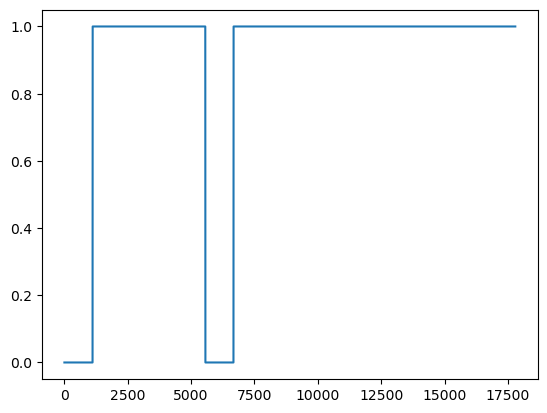

In [115]:
plt.plot(a['train_mask'])

In [107]:
train_set, val_set, test_set = split_dataset(ds,
                                             frac_list=[0.8, 0.1, 0.1],
                                             shuffle=True,
                                             random_state=0)

In [487]:
files = glob.glob('D:\\ISSM\\version2\\transient_y20_r*.mat')

for filename in tqdm(files[:1]):

    rate = float(filename[-7:-4])
    test = sio.loadmat(filename)

    xc = test['S'][0][0][0]
    yc = test['S'][0][0][1]
    elements = test['S'][0][0][2]-1

    smb = test['S'][0][0][3]
    vx = test['S'][0][0][4]
    vy = test['S'][0][0][5]
    vel = test['S'][0][0][6]
    H = test['S'][0][0][7]
    f = test['S'][0][0][8]


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.12it/s]


In [491]:
xc.max()

xmax = -1360067.937381
xmin = -1794277.962227
ymax = 63667.6809196406
ymin = -373562.027065861

-1360067.937381

In [494]:
yc.max() - yc.min()

437229.70798550156

In [66]:
class PIGDataset(DGLDataset):
    def __init__(self):
        super().__init__(name='pig')
        
    def process(self):
        self.graphs = []
        
        files = glob.glob('D:\\ISSM\\version2\\transient_y20_r*.mat')

        for filename in tqdm(files[:]):

            rate = float(filename[-7:-4])
            test = sio.loadmat(filename)

            xc = test['S'][0][0][0]
            yc = test['S'][0][0][1]
            elements = test['S'][0][0][2]-1

            smb = test['S'][0][0][3]
            vx = test['S'][0][0][4]
            vy = test['S'][0][0][5]
            vel = test['S'][0][0][6]
            H = test['S'][0][0][7]
            f = test['S'][0][0][8]

            n_year, n_sample = H.shape

            for t in range(0, n_year):

                src = []
                dst = []
                weight = []
                inputs = torch.zeros([n_sample, 4])
                outputs = torch.zeros([n_sample, 6])

                for i in range(0, n_sample):        
                    inputs[i, :] = torch.tensor([(xc[i, 0]-xc.min())/(xc.max()-xc.min()), (yc[i, 0]-yc.min())/(yc.max()-yc.min()), rate*0.001, t/n_year])
                    outputs[i, :] = torch.tensor([smb[t,i], vx[t, i]/5000, vy[t, i]/5000, vel[t,i]/5000, H[t,i]/4000, f[t,i]/3000])

                    p1, p2 = np.where(elements == i)

                    for p in p1:
                        for k in elements[p]:
                            if k != i:
                                dist = ((xc[i]-xc[k])**2+(yc[i]-yc[k])**2)**0.5
                                weight.append(np.exp(-(dist/1000)))
                                src.append(int(i))
                                dst.append(int(k))

                src = torch.tensor(src)
                dst = torch.tensor(dst)
                weight = torch.tensor(weight)
                
                train_mask = torch.zeros(n_sample, dtype=torch.bool)
                val_mask = torch.zeros(n_sample, dtype=torch.bool)
                test_mask = torch.zeros(n_sample, dtype=torch.bool)        
                                        
                if rate % 100 == 0:
                    test_mask[:] = True
                else:
                    if t % 10 == 5:
                        val_mask[:] = True
                    else:
                        train_mask[:] = True

                g = dgl.graph((src, dst), num_nodes=n_sample)
                g.ndata['feat'] = inputs
                g.ndata['label'] = outputs
                g.edata['weight'] = weight
                
                g.ndata['train_mask'] = train_mask
                g.ndata['val_mask'] = val_mask
                g.ndata['test_mask'] = test_mask

                self.graphs.append(g)
        
    def __getitem__(self, i):
        return self.graphs[i]
    
    def __len__(self):
        return len(self.graphs)

5

In [ ]:
import os
from dgl import save_graphs, load_graphs
from dgl.data.utils import makedirs, save_info, load_info

def save(self):
    # save graphs and labels
    graph_path = os.path.join(self.save_path, self.mode + '_dgl_graph.bin')
    save_graphs(graph_path, self.graphs)

In [70]:
train_mask = torch.zeros(5, dtype=torch.bool)
print(train_mask)

tensor([False, False, False, False, False])


In [71]:
train_mask[:] = True
print(train_mask)

tensor([True, True, True, True, True])


In [60]:
from dgl.data.utils import save_graphs, load_graphs

save_graphs("../data/PIG_DGL_dataset.bin", dataset.graphs)

In [4]:
import dgl
from dgl.data import DGLDataset
import torch
import os

nodes_data = pd.read_csv('./members.csv')
edges_data = pd.read_csv('./interactions.csv')
node_features = torch.from_numpy(nodes_data['Age'].to_numpy())
node_labels = torch.from_numpy(nodes_data['Club'].astype('category').cat.codes.to_numpy())
edge_features = torch.from_numpy(edges_data['Weight'].to_numpy())
edges_src = torch.from_numpy(edges_data['Src'].to_numpy())
edges_dst = torch.from_numpy(edges_data['Dst'].to_numpy())

self.graph = dgl.graph((edges_src, edges_dst), num_nodes=nodes_data.shape[0])
self.graph.ndata['feat'] = node_features
self.graph.ndata['label'] = node_labels
self.graph.edata['weight'] = edge_features

# If your dataset is a node classification dataset, you will need to assign
# masks indicating whether a node belongs to training, validation, and test set.
n_nodes = nodes_data.shape[0]
n_train = int(n_nodes * 0.6)
n_val = int(n_nodes * 0.2)
train_mask = torch.zeros(n_nodes, dtype=torch.bool)
val_mask = torch.zeros(n_nodes, dtype=torch.bool)
test_mask = torch.zeros(n_nodes, dtype=torch.bool)
train_mask[:n_train] = True
val_mask[n_train:n_train + n_val] = True
test_mask[n_train + n_val:] = True
self.graph.ndata['train_mask'] = train_mask
self.graph.ndata['val_mask'] = val_mask
self.graph.ndata['test_mask'] = test_mask

NameError: name 'self' is not defined

In [243]:
[smb[t,i], vx[t, i]/5000, vy[t, i]/5000, vel[t,i]/5000, H[t,i]/4000, f[t,i]/3000]

[0.0, 0.0, 0.0, 0.0, 0.21530319302977352, 0.048929327435487724]

In [177]:
for p in p1:
    for k in elements[p]:
        if k != i:
            dist = ((xc[i]-xc[k])**2+(yc[i]-yc[k])**2)**0.5
            print(i, k, dist)

610 574 [12650.39032726]
610 802 [10220.67101742]
610 754 [12001.37940491]
610 639 [8319.75320918]
610 639 [8319.75320918]
610 307 [17568.43501514]
610 574 [12650.39032726]
610 754 [12001.37940491]
610 970 [16694.73632063]
610 307 [17568.43501514]
610 970 [16694.73632063]
610 271 [7690.12539609]
610 271 [7690.12539609]
610 802 [10220.67101742]


In [258]:
train_list = torch.load(f'../data/Graph_train_data_v2.pt')
val_list = torch.load(f'../data/Graph_val_data_v2.pt')   

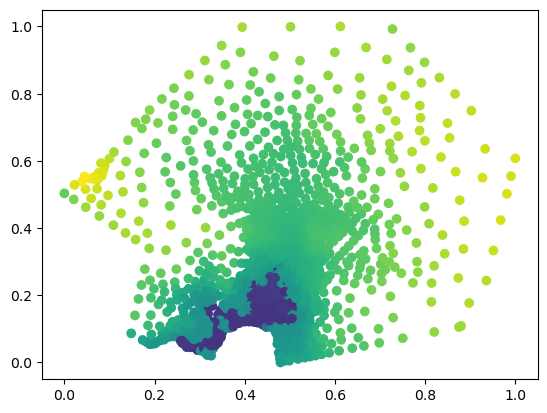

In [261]:
plt.scatter(train_list[0].x[:,0], train_list[0].x[:,1], c = train_list[4].y[:,5])

In [162]:
p1

0.999000499833375

In [148]:
import torch
from torch.nn.functional import normalize

# define a torch tensor
t = torch.tensor([1., 2., 3., -2., -5.])

# print the above tensor
print("Tensor:", t)

# normalize the tensor
t1 = normalize(t, p=1.0, dim = 0)
t2 = normalize(t, p=2.0, dim = 0)

# print normalized tensor
print("Normalized tensor with p=1:", t1)
print("Normalized tensor with p=2:", t2)

Tensor: tensor([ 1.,  2.,  3., -2., -5.])
Normalized tensor with p=1: tensor([ 0.0769,  0.1538,  0.2308, -0.1538, -0.3846])
Normalized tensor with p=2: tensor([ 0.1525,  0.3050,  0.4575, -0.3050, -0.7625])


In [153]:
nodes = data.x
coors = data.x[:, :2]

In [154]:
n_nodes = nodes.shape[0]
edges = torch.zeros([1, n_nodes, n_nodes, 1])
for i in tqdm(range(0, n_nodes)):
    for j in range(0, n_nodes):
        if i != j:
            d = ((coors[i, 0] - coors[j, 0])**2 + (coors[i, 1] - coors[j, 1])**2)**0.5
            edges[0, i, j, 0] = 1/d

 44%|████████████████████████████████▊                                         | 494/1112 [01:15<01:34,  6.54it/s]


KeyboardInterrupt: 

In [177]:
def make_all_connection(nodes, coors):
    n_nodes = nodes.shape[0]
    edges = torch.zeros([1, n_nodes, n_nodes, 1])
    for i in tqdm(range(0, n_nodes)):
        for j in range(0, n_nodes):
            if i != j:
                d = ((coors[i, 0] - coors[j, 0])**2 + (coors[i, 1] - coors[j, 1])**2)**0.5
                edges[0, i, j, 0] = d
    return edges
            

val_list = torch.load(f'../Grid_graph_val_data.pt')
train_list = torch.load(f'../Grid_graph_train_data.pt')

data = train_list[0]
edges = make_all_connection(data.x, data.x[:, :2])
print("Edges created")

100%|█████████████████████████████████████████████████████████████████████████| 1112/1112 [02:06<00:00,  8.78it/s]


Edges created


100%|██████████████████████████████████████████████████████████████████████| 1800/1800 [00:00<00:00, 23025.38it/s]


In [197]:
torch.zeros([len(train_list), train_list[0].x.shape[0], train_list[0].x.shape[1]]).shape

torch.Size([2520, 1112, 4])

In [199]:
train_list2 = {}
train_list2['x'] = torch.zeros([len(train_list), train_list[0].x.shape[0], train_list[0].x.shape[1]])
train_list2['coors'] = torch.zeros([len(train_list), train_list[0].x.shape[0], 2])
train_list2['y'] = torch.zeros([len(train_list), train_list[0].y.shape[0], train_list[0].y.shape[1]])
train_list2['edges'] = edges

val_list2 = {}
val_list2['x'] = torch.zeros([len(val_list), val_list[0].x.shape[0], val_list[0].x.shape[1]])
val_list2['coors'] = torch.zeros([len(val_list), val_list[0].x.shape[0], 2])
val_list2['y'] = torch.zeros([len(val_list), val_list[0].y.shape[0], val_list[0].y.shape[1]])
val_list2['edges'] = edges

for i in tqdm(range(0, len(train_list))):
    data = train_list[i]
    train_list2['x'][i] = data.x[:]
    train_list2['coors'][i] = data.x[:, :2]
    train_list2['y'][i] = data.y[:]
    # dic['edge_weight'] = data.edge_weight 

for i in tqdm(range(0, len(val_list))):
    data = train_list[i]
    val_list2['x'][i] = data.x[:]
    val_list2['coors'][i] = data.x[:, :2]
    val_list2['y'][i] = data.y[:]
    
torch.save(train_list2, f'../data/Graph_y20_train_data.pt')
torch.save(val_list2, f'../data/Graph_y20_val_data.pt')

100%|██████████████████████████████████████████████████████████████████████| 1800/1800 [00:00<00:00, 12515.12it/s]


In [201]:
train_list2['x'].shape

torch.Size([2520, 1112, 4])

In [140]:
from torch_geometric.loader import NeighborLoader

train_loader = NeighborLoader(
    train_list[1],
    num_neighbors=[25, 10],
    batch_size=16,
    num_workers=1,
)

In [281]:
import torch
from egnn_pytorch import EGNN_Network

net = EGNN_Network(
    num_tokens = 21,
    num_positions = 1024,           # unless what you are passing in is an unordered set, set this to the maximum sequence length
    dim = 32,
    depth = 3,
    num_nearest_neighbors = 8,
    coor_weights_clamp_value = 2.   # absolute clamped value for the coordinate weights, needed if you increase the num neareest neighbors
)

feats = torch.randint(0, 21, (1, 1024)) # (1, 1024)
coors = torch.randn(1, 1024, 3)         # (1, 1024, 3)
mask = torch.ones_like(feats).bool()    # (1, 1024)

feats_out, coors_out = net(feats, coors, mask = mask)

In [277]:
edges.shape

torch.Size([1, 1112, 1112, 1])

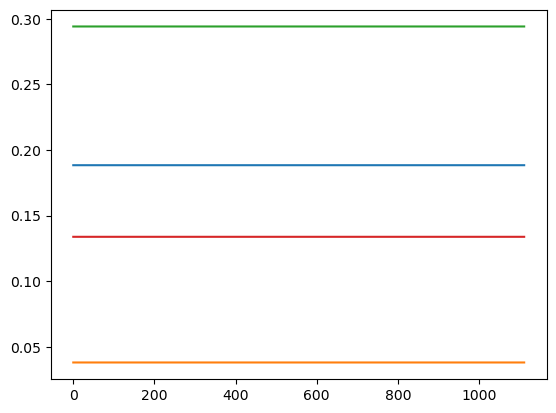

In [233]:
plt.plot(abs(feats1-feats)[0].detach().numpy())

In [263]:
scaling = [1, 5000, 5000, 5000, 4000]
# y_pred = np.zeros([len(val_list), 1112, 5])
# y_true = np.zeros([len(val_list), 1112, 5])
count = 0
for k in tqdm(range(0, len(val_list))):
    data = val_list[k]
    # prd = net(data.x.to(torch.float).to(device), data.edge_index.to(device)).to('cpu').detach().numpy()
    # tru = data.y.to('cpu').detach().numpy()
    # for i in range(0, prd.shape[1]):
    #     prd[:, i] = prd[:, i]*scaling[i]
    #     tru[:, i] = tru[:, i]*scaling[i]
    # y_pred[k] = prd
    # y_true[k] = tru
    # count += 1
    
# result_file = "../results/test_torch_egcn_nophy_gpu.pkl"

# with open(result_file, 'rb') as file:
#     [rates, years, y_true0, y_pred0] = pickle.load(file)  

100%|██████████████████████████████████████████████████████████████████████| 1920/1920 [00:00<00:00, 1911933.45it/s]


In [264]:
xc = data.x[:,0].to('cpu').detach().numpy()
yc = data.x[:,1].to('cpu').detach().numpy()

In [65]:
rmse_rate = np.zeros([y_true0.shape[2], len(np.unique(rates))])
for i, r in enumerate(np.unique(rates)):
    idx = (rates==r)
    y_true = y_true0[idx]
    y_pred = y_pred0[idx]
    
    for c in range(0, y_true0.shape[2]):
        rmse_rate[c, i] = RMSE(y_true[:, :, c], y_pred[:, :, c])
        
rmse_year = np.zeros([y_true0.shape[2], len(np.unique(years))])
for i, y in enumerate(np.unique(years)):
    idx = (years==y) & (rates*100%10==0)
    y_true = y_true0[idx]
    y_pred = y_pred0[idx]
    
    for c in range(0, y_true0.shape[2]):
        rmse_year[c, i] = RMSE(y_true[:, :, c], y_pred[:, :, c])

test_rates = [0.0, 0.2, 0.4, 0.6]
rmse_all = np.zeros([y_true0.shape[2], len(test_rates), 240])
for i, r in enumerate(test_rates):
    for j, y in enumerate(np.unique(years)):
        
        idx = (rates==r) & (years==y)
        y_true = y_true0[idx]
        y_pred = y_pred0[idx]

        for c in range(0, y_true0.shape[2]):
            rmse_all[c, i, j] = RMSE(y_true[:, :, c], y_pred[:, :, c])
    

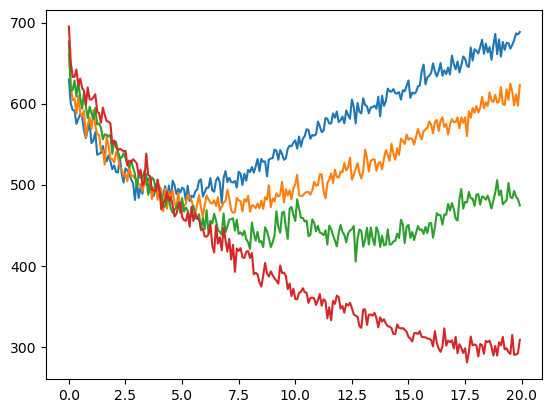

In [69]:
for i in range(0, 4):
    plt.plot(np.unique(years), rmse_all[3, i, :])

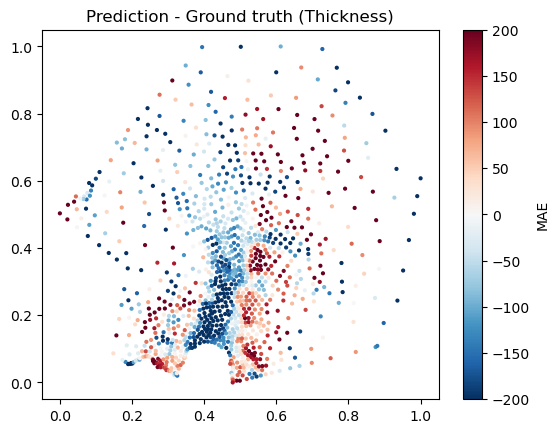

In [75]:
ind = 10
c = 4

channels = ["SMB", "U velocity", "V velocity", "Velocity", "Thickness"]
vmax = [1, 400, 400, 4000, 2000]
vmin = [0, -400, -400, 0, 0]

err = np.mean((y_pred0 - y_true0), axis=0)
plt.title(f"Prediction - Ground truth ({channels[c]})")
plt.scatter(xc, yc, c = err[:, c], s = 4, cmap = "RdBu_r", vmin = -200, vmax = 200)
plt.colorbar(label = "MAE")

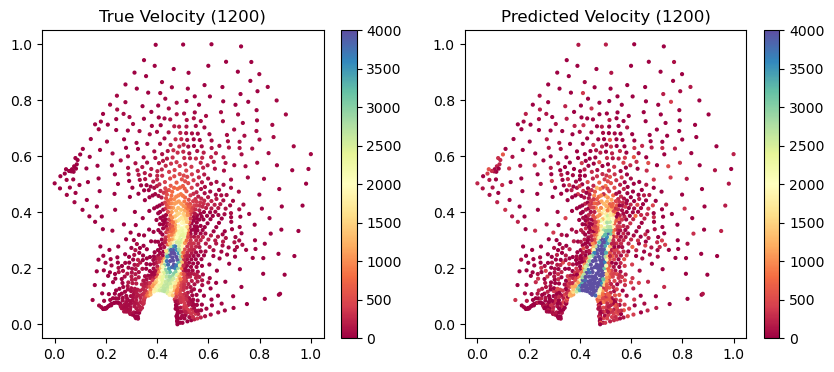

In [76]:
ind = 1200
c = 3
err = np.mean(abs(y_pred - y_true), axis=0)


fig, ax = plt.subplots(1,2, figsize = (10,4))
c1 = ax[0].scatter(xc, yc, c = y_true0[ind, :, c], s = 4, vmin = vmin[c], vmax = vmax[c], cmap = "Spectral")
ax[0].set_title(f"True {channels[c]} ({ind})")
fig.colorbar(c1, ax = ax[0])
c2 = ax[1].scatter(xc, yc, c = y_pred0[ind, :, c], s = 4, vmin = vmin[c], vmax = vmax[c], cmap = "Spectral")
ax[1].set_title(f"Predicted {channels[c]} ({ind})")
fig.colorbar(c1, ax = ax[1])

## GCN results

In [4]:
val_list = torch.load(f'../data/Grid_graph_val_data.pt')
train_list = torch.load(f'../data/Grid_graph_train_data.pt')

xc = val_list[0].x[:, 0]
yc = val_list[0].x[:, 1]

In [34]:
for i in range(0, len(train_list)):
    train_list[i].y = train_list[i].y[:, [1,2,4]]

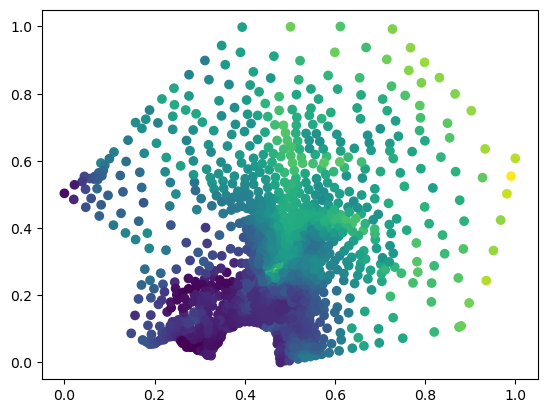

In [35]:
plt.scatter(xc, yc, c = train_list[0].y[:, 2])

In [5]:
scaling = [1, 5000, 5000, 5000, 4000]
# y_pred = np.zeros([len(val_list), 1112, 5])
# y_true = np.zeros([len(val_list), 1112, 5])
count = 0
for k in tqdm(range(0, len(val_list))):
    data = val_list[k]
    # prd = net(data.x.to(torch.float).to(device), data.edge_index.to(device)).to('cpu').detach().numpy()
    # tru = data.y.to('cpu').detach().numpy()
    # for i in range(0, prd.shape[1]):
    #     prd[:, i] = prd[:, i]*scaling[i]
    #     tru[:, i] = tru[:, i]*scaling[i]
    # y_pred[k] = prd
    # y_true[k] = tru
    # count += 1

model_type = ["egcn", "gcn", "fcn"]
result_file = "../results/test_torch_gcn_lr0.001_nophy_gpu.pkl"

with open(result_file, 'rb') as file:
    [rates, years, y_true0, y_pred0] = pickle.load(file)  

100%|██████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:00<?, ?it/s]


In [350]:
vel = np.expand_dims((y_true0[:, :, 0]**2 + y_true0[:, :, 1]**2)**0.5, axis = 2)
a = np.append(y_true0, vel, axis = 2)
a.shape

(1920, 1112, 4)

In [349]:
np.expand_dims((y_true0[:, :, 0]**2 + y_true0[:, :, 1]**2)**0.5, axis = 2)

(1920, 1112, 1)

In [103]:
def add_vel(y_true0):
    vel = np.expand_dims((y_true0[:, :, 0]**2 + y_true0[:, :, 1]**2)**0.5, axis = 2)
    y_true0 = np.append(y_true0, vel, axis = 2)
    return y_true0
    
model_types = ["mlp", "egcn", "gcn", "gat"]
test_rates = [0.0, 0.2, 0.4, 0.6]
rmse_all = {}
r_all = {}

ch = 6
if ch == 3:
    scaling = np.array([5000, 5000, 4000, 5000])
elif ch == 6:
    scaling = [1, 5000, 5000, 5000, 4000, 3000]

for model_type in model_types:
    result_file = f"../results/test_torch_dgl_{model_type}_lr0.01_nophy_ch{ch}.pkl"
    with open(result_file, 'rb') as file:
        [rates, years, x_inputs, y_true0, y_pred0] = pickle.load(file)
        if ch == 3:
            y_true0 = add_vel(y_true0) * scaling
            y_pred0 = add_vel(y_pred0) * scaling
        elif ch == 6:
            y_true0 = y_true0 * scaling
            y_pred0 = y_pred0 * scaling
        
    test_rates = np.unique(rates)
    test_years = np.unique(years)
    
    rmse_all[model_type] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
    r_all[model_type] = np.zeros([y_true0.shape[2], len(test_rates), len(test_years)])
    for i, r in enumerate(test_rates):
        for j, y in enumerate(test_years):

            idx = (rates==r) & (years==y)
            
            y_true = y_true0[idx]
            y_pred = y_pred0[idx]
            
            for c in range(0, y_true0.shape[2]):
                rmse_all[model_type][c, i, j] = RMSE(y_true[:, :, c], y_pred[:, :, c])         
                r_all[model_type][c, i, j] = corr(y_true[:, :, c], y_pred[:, :, c])         
    print(result_file)
    
print("DONE!")

../results/test_torch_dgl_mlp_lr0.01_nophy_ch6.pkl
../results/test_torch_dgl_egcn_lr0.01_nophy_ch6.pkl
../results/test_torch_dgl_gcn_lr0.01_nophy_ch6.pkl
../results/test_torch_dgl_gat_lr0.01_nophy_ch6.pkl
DONE!


In [125]:
np.mean(rmse_all['egcn'], axis = (1,2))[3:5]

array([28.62544639, 18.45793971])

In [126]:
np.mean(r_all['egcn'], axis = (1,2))[3:5]

array([0.99963072, 0.99959605])

In [10]:
x_inputs[idx][:, :, 0]

array([[0.18922858, 0.1906192 , 0.19584371, ..., 0.09971562, 0.18201835,
        0.21811007]])

../results/test_torch_dgl_gcn_lr0.01_nophy_ch3.pkl


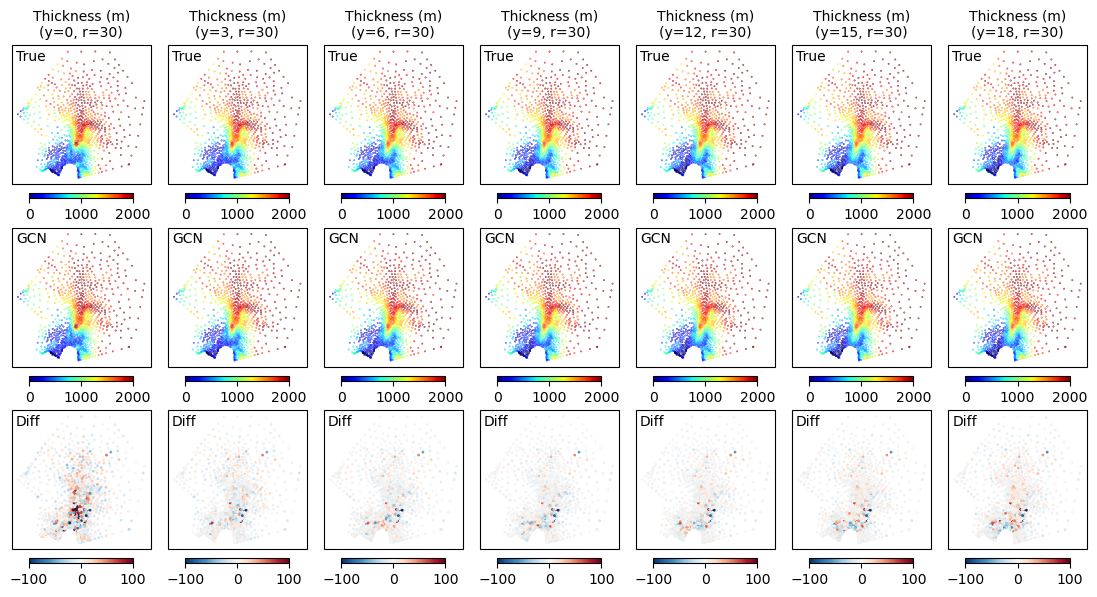

In [17]:
### CHANNEL 3 ###
model_type = "gcn"

result_file = f"../results/test_torch_dgl_{model_type}_lr0.01_nophy_ch3.pkl"
print(result_file)
with open(result_file, 'rb') as file:
    [rates, years, x_inputs, y_true0, y_pred0] = pickle.load(file) 
    y_true0 = add_vel(y_true0)
    y_pred0 = add_vel(y_pred0)

scaling = [5000, 5000, 4000, 5000]

r = test_rates[3]
c = 2

year_list = [0, 3, 6, 9, 12, 15, 18]
vmax = [5000, 5000, 2000, 5000]
vmin = [-5000, -5000, 0, 0]
verr = [200, 200, 100, 200]
cm = ["Spectral", "Spectral", "jet", "jet", "jet", "RdBu"]
channels = ["U velocity", "V velocity", "Thickness (m)", "Floating"]

fig, ax = plt.subplots(3, len(year_list), figsize = (len(year_list)*2, 7), dpi = 100,
                       subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)})
plt.subplots_adjust(hspace=0.05, wspace=0.05)

for j, y in enumerate(year_list):

    idx = (rates==r) & (years==y)

    obsmap = ax[0, j].scatter(x_inputs[idx][:, :, 0], x_inputs[idx][:, :, 1], c = y_true0[idx, :, c]*scaling[c], s = 0.1, cmap = cm[c], vmin = vmin[c], vmax = vmax[c])
    prdmap = ax[1, j].scatter(x_inputs[idx][:, :, 0], x_inputs[idx][:, :, 1], c = y_pred0[idx, :, c]*scaling[c], s = 0.1, cmap = cm[c], vmin = vmin[c], vmax = vmax[c])
    difmap = ax[2, j].scatter(x_inputs[idx][:, :, 0], x_inputs[idx][:, :, 1], c = y_pred0[idx, :, c]*scaling[c] - y_true0[idx, :, c]*scaling[c], s = 1, cmap = "RdBu_r", vmin = -verr[c], vmax = verr[c])

    ax[0, j].annotate(f"True", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
    ax[1, j].annotate(f"{model_type.upper()}", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
    ax[2, j].annotate(f"Diff", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
    
    ax[0, j].set_title(f"{channels[c]}\n(y={y}, r={int(r*100)})", fontsize = 10)
    
    fig.colorbar(obsmap, ax = ax[0,j], orientation = "horizontal", shrink = 0.7, pad = 0.05)
    fig.colorbar(prdmap, ax = ax[1,j], orientation = "horizontal", shrink = 0.7, pad = 0.05)
    fig.colorbar(difmap, ax = ax[2,j], orientation = "horizontal", shrink = 0.7, pad = 0.05)
    

../results/test_torch_dgl_egcn_g5000_lr0.001_nophy_ch6.pkl


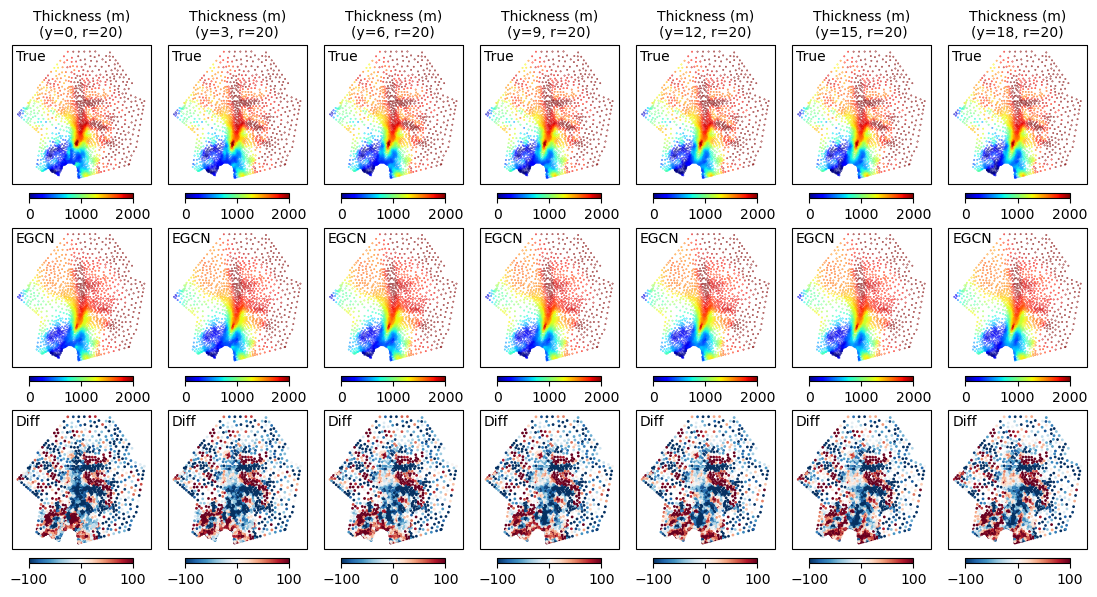

In [130]:
### Channel 6 ###
model_type = "egcn"

result_file = f"../results/test_torch_dgl_{model_type}_g5000_lr0.001_nophy_ch6.pkl"
print(result_file)
with open(result_file, 'rb') as file:
    [rates, years, x_inputs, y_true0, y_pred0] = pickle.load(file) 

r = test_rates[1]
c = 4

scaling = [1, 5000, 5000, 5000, 4000, 3000]
year_list = [0, 3, 6, 9, 12, 15, 18]
vmax = [1, 5000, 5000, 5000, 2000, 3000]
vmin = [0, -5000, -5000, 0, 0, -3000]
verr = [0.01, 200, 200, 200, 100, 100]
cm = ["Spectral", "Spectral", "jet", "jet", "jet", "RdBu"]
channels = ["SMB", "U velocity", "V velocity", "Velocity (m/y)", "Thickness (m)", "Floating"]

fig, ax = plt.subplots(3, len(year_list), figsize = (len(year_list)*2, 7), dpi = 100,
                       subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)})
plt.subplots_adjust(hspace=0.05, wspace=0.05)

for j, y in enumerate(year_list):

    idx = (rates==r) & (years==y)

    obsmap = ax[0, j].scatter(x_inputs[idx][:, :, 0], x_inputs[idx][:, :, 1], c = y_true0[idx, :, c]*scaling[c], s = 0.1, cmap = cm[c], vmin = vmin[c], vmax = vmax[c])
    prdmap = ax[1, j].scatter(x_inputs[idx][:, :, 0], x_inputs[idx][:, :, 1], c = y_pred0[idx, :, c]*scaling[c], s = 0.1, cmap = cm[c], vmin = vmin[c], vmax = vmax[c])
    difmap = ax[2, j].scatter(x_inputs[idx][:, :, 0], x_inputs[idx][:, :, 1], c = y_pred0[idx, :, c]*scaling[c] - y_true0[idx, :, c]*scaling[c], s = 1, cmap = "RdBu_r", vmin = -verr[c], vmax = verr[c])

    ax[0, j].annotate(f"True", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
    ax[1, j].annotate(f"{model_type.upper()}", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
    ax[2, j].annotate(f"Diff", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
    
    ax[0, j].set_title(f"{channels[c]}\n(y={y}, r={int(r*100)})", fontsize = 10)
    
    fig.colorbar(obsmap, ax = ax[0,j], orientation = "horizontal", shrink = 0.7, pad = 0.05)
    fig.colorbar(prdmap, ax = ax[1,j], orientation = "horizontal", shrink = 0.7, pad = 0.05)
    fig.colorbar(difmap, ax = ax[2,j], orientation = "horizontal", shrink = 0.7, pad = 0.05)


In [804]:
y_true0[rates == r].shape
diff = (y_true0[rates == r][1:] - y_true0[rates == r][:-1]) * np.array(scaling)
diff.shape

(239, 1112, 6)

In [715]:
np.sum(smb1)

521.7502905353904

In [716]:
np.sum(diff[100, :, 4])

183.8450520299375

In [718]:
div

tensor([-0.8078, -0.4835,  0.1787,  ...,  0.1275, -0.5194, -0.7762])

In [721]:
torch.sum(adv)

tensor(11315.0312)

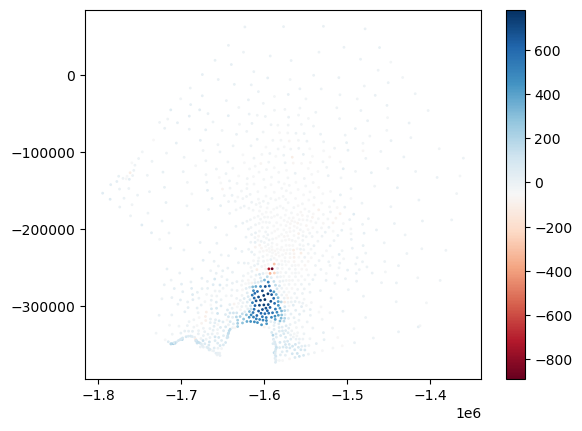

In [666]:
c = 4
plt.scatter(xc, yc, c = y_true0[rates == r][239, :, c]*scaling[c] - y_true0[rates == r][0, :, c]*scaling[c], s= 1, cmap = "RdBu")
plt.colorbar()

In [638]:
smb1 = y_true0[0, :, 0]*scaling[c]
smb2 = y_true0[100, :, 0]*scaling[c]

In [628]:
smb2 = y_true0[idx, :, c]*scaling[c]

In [703]:
def divergence(nodes, edges, u, v, h, x, y):
    div = torch.zeros(nodes.shape)
    adv = torch.zeros(nodes.shape)
    
    for n1 in nodes:
        ind = torch.where(edges[0] == n1)[0]
        cnt = len(ind)
        for i in ind:
            n2 = edges[1][i.item()]
            if abs(x[n2]-x[n1]) > 0:
                adv[n1] += (u[n1]*(h[n2]-h[n1])/(x[n2]-x[n1]))/cnt
                div[n1] += (h[n1]*(u[n2]-u[n1])/(x[n2]-x[n1]))/cnt
            if abs(y[n2]-y[n1]) > 0:
                adv[n1] += (v[n1]*(h[n2]-h[n1])/(y[n2]-y[n1]))/cnt
                div[n1] += (h[n1]*(v[n2]-v[n1])/(y[n2]-y[n1]))/cnt

            if abs(adv[n1].item()) > 1000:
                print(n1, n2 , "H: ", h[n2].item()-h[n1].item(), "U: ", u[n2].item()-u[n1].item(), "V: ", v[n2].item()-v[n1].item(),
                      "X/Y: ", x[n2]-x[n1], y[n2]-y[n1], adv[n1].item(), div[n1].item())
                
    return div/12, adv/12

In [727]:
p1 = np.array([1, 2, 3])
p2 = np.array([4, 6, 9])
p3 = np.array([12, 11, 9])

# These two vectors are in the plane
v1 = p3 - p1
v2 = p2 - p1

# the cross product is a vector normal to the plane
cp = np.cross(v1, v2)
a, b, c = cp

## Calculate divergence with finite element

In [309]:
def get_gradient(v1, v2, v3):
    # input: vector 1, vector 2, vector 3 (3 dimension of [x, y, z]; z should be height, u or v velocity, etc.)
    a1 = v3 - v1
    a2 = v2 - v1
    a, b, c = torch.cross(a1, a2)
    # Plane equation: ax + by + cz = d --> cz = -ax - by + d
    # dz/dx = -a/c
    # dz/dy = -b/c
    dzdx = -a/c
    dzdy = -b/c
    return dzdx, dzdy
    

def div_nodes(nodes, elements, u, v, h, x, y):
    div = torch.zeros(nodes.shape) #torch.zeros(elements.shape[0])
    adv = torch.zeros(nodes.shape) # torch.zeros(elements.shape[0])
    count = torch.zeros(nodes.shape)
    area = torch.zeros(nodes.shape)
    
    xx = torch.zeros(elements.shape[0])
    yy = torch.zeros(elements.shape[0])
    i = 0
    
    for p1, p2, p3 in tqdm(elements):
        h1 = torch.tensor([x[p1], y[p1], h[p1]])
        h2 = torch.tensor([x[p2], y[p2], h[p2]])
        h3 = torch.tensor([x[p3], y[p3], h[p3]])
        dhdx, dhdy = get_gradient(h1, h2, h3)
        
        u1 = torch.tensor([x[p1], y[p1], u[p1]])
        u2 = torch.tensor([x[p2], y[p2], u[p2]])
        u3 = torch.tensor([x[p3], y[p3], u[p3]])
        dudx, dudy = get_gradient(u1, u2, u3)
        
        v1 = torch.tensor([x[p1], y[p1], v[p1]])
        v2 = torch.tensor([x[p2], y[p2], v[p2]])
        v3 = torch.tensor([x[p3], y[p3], v[p3]])
        dvdx, dvdy = get_gradient(v1, v2, v3)
        
        dive = (h[p1]+h[p2]+h[p3])/3*(dudx+dvdy) # divergence of element
        adve = (u[p1]+u[p2]+u[p3])/3*dhdx + (v[p1]+v[p2]+v[p3])/3*dhdy # advection of element
        
        adv[p1] += adve
        div[p1] += dive
        adv[p2] += adve
        div[p3] += dive
        adv[p1] += adve
        div[p3] += dive
        
        count[p1] += 1
        count[p2] += 1
        count[p3] += 1
        
        i += 1        
    
    adv = adv / count
    div = div / count
    
    return div/12, adv/12

def div_elements(nodes, elements, u, v, h, x, y):
    div = torch.zeros(elements.shape[0]) #torch.zeros(elements.shape[0])
    adv = torch.zeros(elements.shape[0]) # torch.zeros(elements.shape[0])
    count = torch.zeros(elements.shape[0])
    area = torch.zeros(elements.shape[0])
    
    xx = torch.zeros(elements.shape[0])
    yy = torch.zeros(elements.shape[0])
    i = 0
    
    for p1, p2, p3 in tqdm(elements):
        h1 = torch.tensor([x[p1], y[p1], h[p1]])
        h2 = torch.tensor([x[p2], y[p2], h[p2]])
        h3 = torch.tensor([x[p3], y[p3], h[p3]])
        dhdx, dhdy = get_gradient(h1, h2, h3)
        
        u1 = torch.tensor([x[p1], y[p1], u[p1]])
        u2 = torch.tensor([x[p2], y[p2], u[p2]])
        u3 = torch.tensor([x[p3], y[p3], u[p3]])
        dudx, dudy = get_gradient(u1, u2, u3)
        
        v1 = torch.tensor([x[p1], y[p1], v[p1]])
        v2 = torch.tensor([x[p2], y[p2], v[p2]])
        v3 = torch.tensor([x[p3], y[p3], v[p3]])
        dvdx, dvdy = get_gradient(v1, v2, v3)
        
        dive = (h[p1]+h[p2]+h[p3])/3*(dudx+dvdy) # divergence of element
        adve = (u[p1]+u[p2]+u[p3])/3*dhdx + (v[p1]+v[p2]+v[p3])/3*dhdy # advection of element
        
        adv[i] = adve
        div[i] = dive
        area[i] = 0.5 * abs(x[p1]*(y[p2]-y[p3]) + x[p2]*(y[p3]-y[p1]) + x[p3]*(y[p1]-y[p2]))
        xx[i] = (x[p1] + x[p2] + x[p3])/3
        yy[i] = (y[p1] + y[p2] + y[p3])/3
        
        count[i] += 1

        i += 1        
    
    adv = adv
    div = div
    
    return div, adv, area, xx, yy

def mean_elements(nodes, elements, org, x, y):
    output = torch.zeros(elements.shape[0])
    count = torch.zeros(elements.shape[0])
    
    xx = torch.zeros(elements.shape[0])
    yy = torch.zeros(elements.shape[0])
    i = 0
    
    for p1, p2, p3 in tqdm(elements):
        
        output[i] = (org[p1] + org[p2] + org[p3])/3
        
        count[i] += 1
        
        i += 1        
    
    return output

In [351]:
g0 = test_set[0]
g = test_set[1]
u = g.ndata['label'][:, 0] * 5000
v = g.ndata['label'][:, 1] * 5000
h = g.ndata['label'][:, 3] * 4000
h0 = g0.ndata['label'][:, 3] * 4000
f = g.ndata['label'][:, 4]

xmax = -1360067.937381
xmin = -1794277.962227
ymax = 63667.6809196406
ymin = -373562.027065861

smb = g.ndata['feat'][:, 4]
r = g.ndata['feat'][:, 2] * 100
x = g.ndata['feat'][:, 0] * (xmax-xmin) + xmin
y = g.ndata['feat'][:, 1] * (ymax-ymin) + ymin

nodes = g.nodes()
edges = g.edges()

smb = mean_elements(nodes, elements, smb, x, y)
r = mean_elements(nodes, elements, r, x, y)
f = mean_elements(nodes, elements, f, x, y)
h = mean_elements(nodes, elements, h, x, y)
h0 = mean_elements(nodes, elements, h0, x, y)
dh = (h - h0)*12

# div, adv = div_nodes(nodes, elements, u, v, h, x, y)
div, adv, area, xx, yy = div_elements(nodes, elements, u, v, h, x, y)

100%|███████████████████████████████████████████████████████████████████████| 2085/2085 [00:01<00:00, 1043.54it/s]


In [323]:
g = test_set[200]
r = g.ndata['feat'][:, 3]

In [324]:
r

tensor([0.8333, 0.8333, 0.8333,  ..., 0.8333, 0.8333, 0.8333])

In [352]:
print("Melting rate: ", torch.sum(r[f < 0]).item())
print("SMB: ", torch.sum(smb).item())
print("Ms-Mb=", torch.sum(smb).item() - torch.sum(r[f < 0]).item())
print("Advection: ", torch.sum(adv).item())
print("dh/dt: ", torch.sum(dh).item())
print(torch.sum(adv) + torch.sum(dh))

Melting rate:  0.0
SMB:  1002.6613159179688
Ms-Mb= 1002.6613159179688
Advection:  -728.97705078125
dh/dt:  3811.00732421875
tensor(3082.0303)


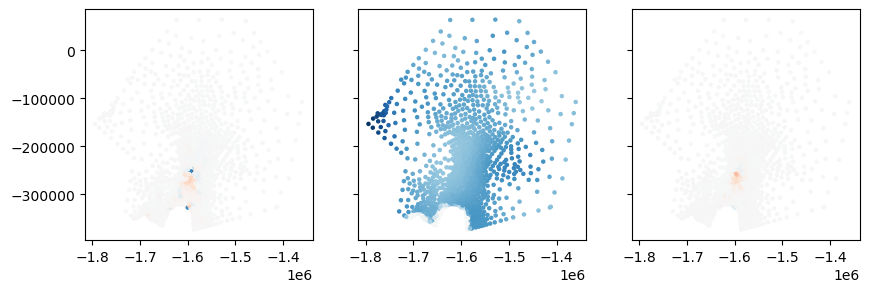

In [345]:
fig, ax = plt.subplots(1,3, figsize = (10, 3), sharey = True)
ax[0].scatter(x, y, c = dh, s=5, vmin = -100, vmax = 100, cmap = "RdBu")
ax[1].scatter(x, y, c = smb, s=5, vmin = -1, vmax = 1, cmap = "RdBu")
ax[2].scatter(x, y, c = adv, s=5, vmin = -100, vmax = 100, cmap = "RdBu")

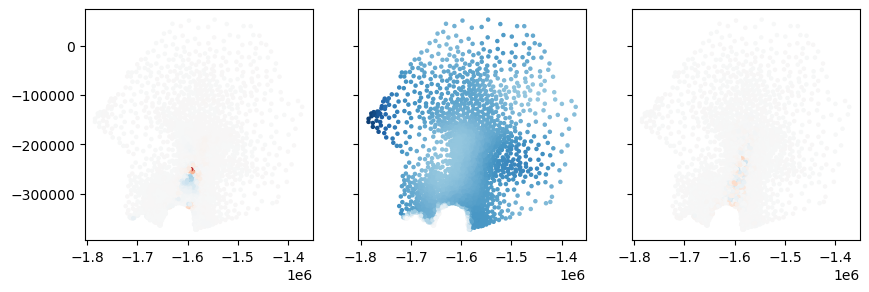

In [356]:
fig, ax = plt.subplots(1,3, figsize = (10, 3), sharey = True)
ax[0].scatter(xx, yy, c = dh, s=5, vmin = -1000, vmax = 1000, cmap = "RdBu")
ax[1].scatter(xx, yy, c = smb, s=5, vmin = -1, vmax = 1, cmap = "RdBu")
ax[2].scatter(xx, yy, c = adv, s=5, vmin = -500, vmax = 500, cmap = "RdBu")

In [193]:
torch.sum(g.ndata['feat'][:, 4])

tensor(1169.7433)

In [230]:
torch.sum(adv)

tensor(-14819.9248)

In [224]:
torch.sum(dh)

tensor(266.3144)

In [667]:
class ISSM_train_dataset(DGLDataset):
    def __init__(self):
        super().__init__(name='pig')
        
    def process(self):
        glist, _ = load_graphs("../data/DGL_train_dataset.bin")
        self.graphs = glist
        
    def __getitem__(self, i):
        return self.graphs[i]
    
    def __len__(self):
        return len(self.graphs)
    
class ISSM_test_dataset(DGLDataset):
    def __init__(self):
        super().__init__(name='pig')
        
    def process(self):
        glist, _ = load_graphs("../data/DGL_test_dataset.bin")
        self.graphs = glist
        
    def __getitem__(self, i):
        return self.graphs[i]
    
    def __len__(self):
        return len(self.graphs)
    
test_set = ISSM_test_dataset()
train_set = ISSM_train_dataset()
g = test_set[0]

In [806]:
0.0042*20

0.08399999999999999

In [807]:
g.ndata

{'feat': tensor([[0.1892, 0.0547, 0.0000, 0.0042],
        [0.1906, 0.0554, 0.0000, 0.0042],
        [0.1958, 0.0554, 0.0000, 0.0042],
        ...,
        [0.0997, 0.6065, 0.0000, 0.0042],
        [0.1820, 0.0612, 0.0000, 0.0042],
        [0.2181, 0.0698, 0.0000, 0.0042]]), 'label': tensor([[ 1.7547e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.0537e-01,
          7.2737e-03],
        [ 2.3532e-02, -1.6059e-06, -6.5692e-04,  6.5692e-04,  2.0261e-01,
          8.9995e-03],
        [ 0.0000e+00,  0.0000e+00, -4.0601e-04,  4.0601e-04,  1.9788e-01,
          1.1593e-02],
        ...,
        [ 7.6653e-01,  2.1960e-03,  1.4420e-03,  2.6272e-03,  2.9240e-01,
          4.1286e-01],
        [ 3.9708e-01,  4.8939e-03, -1.3660e-02,  1.4510e-02,  2.0427e-01,
          2.9637e-02],
        [ 0.0000e+00,  2.3355e-03, -1.2533e-02,  1.2749e-02,  1.5161e-01,
          3.0288e-02]])}

In [528]:
np.sum(smb[230])

521.750289855958

In [529]:
np.sum(smb[2])

521.750289855958

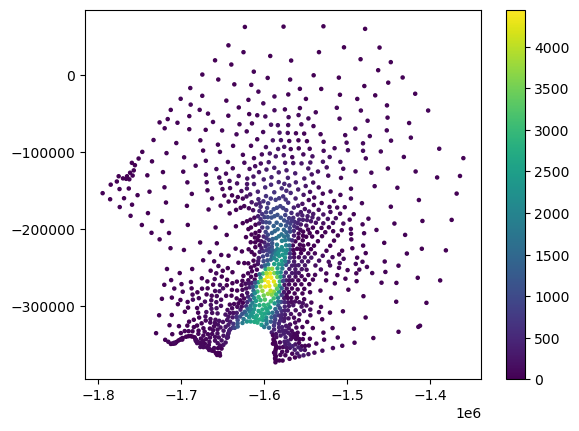

In [679]:
plt.scatter(x, y, c = (u**2 + v**2)**0.5, s= 5)
plt.colorbar()

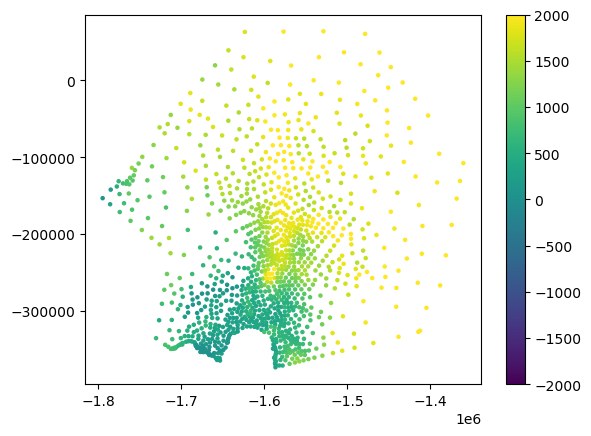

In [550]:
plt.scatter(x, y, c = h, s= 5, vmax = 2000, vmin = -2000)
plt.colorbar()

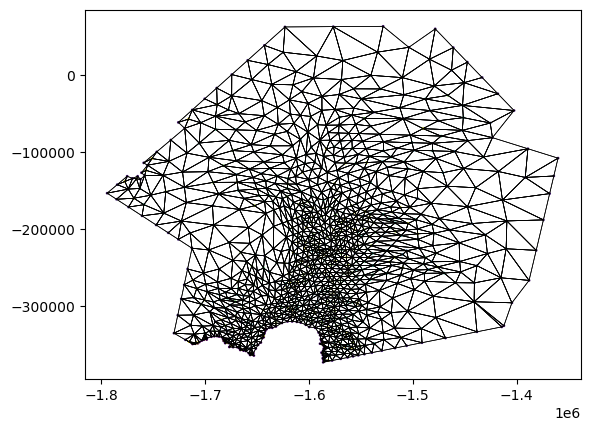

In [604]:

for i in range(0, len(edges[0])):
    plt.plot([x[edges[0][i]], x[edges[1][i]]], [y[edges[0][i]], y[edges[1][i]]], color = "k", lw = 0.5)
plt.scatter(x, y, c = nodes, s = 1)

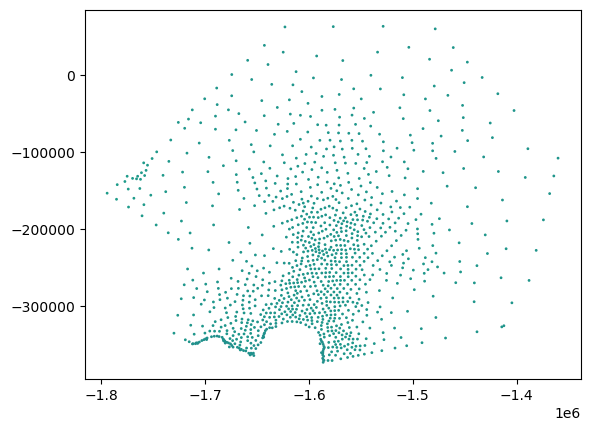

In [702]:
plt.scatter(x, y, c = smb1, s = 1, vmin = -10, vmax = 10)

In [779]:
div

tensor([-7.0263, -8.5698, -4.6533,  ...,  2.6251, -4.2824, -4.4054])

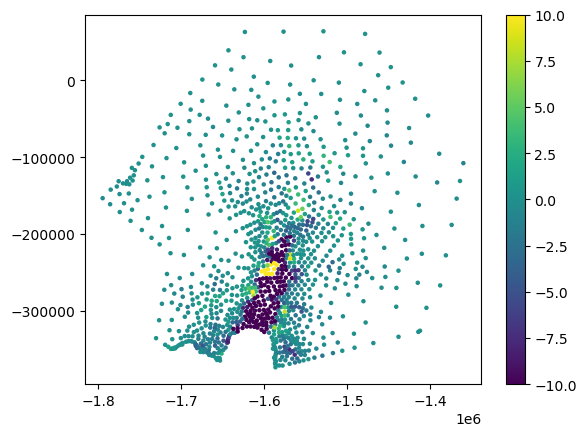

In [794]:
plt.scatter(x, y, c = adv, s= 5, vmin = -10, vmax = 10)
plt.colorbar()

In [798]:
torch.sum(torch.tensor(diff[0, :, 4])*12 + adv + div)

tensor(60.9782, dtype=torch.float64)

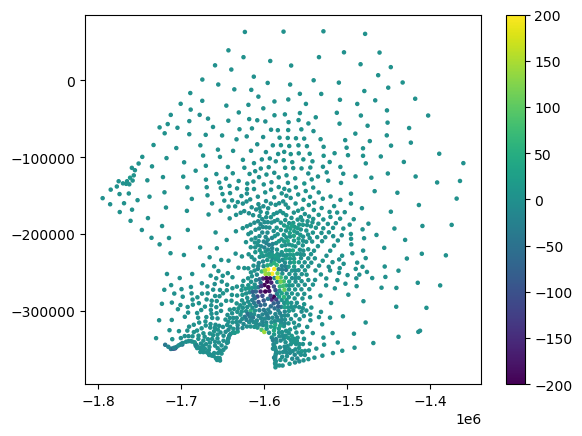

In [821]:
plt.scatter(x, y, c = adv + div, s=5, vmin = -200, vmax = 200)
plt.colorbar()

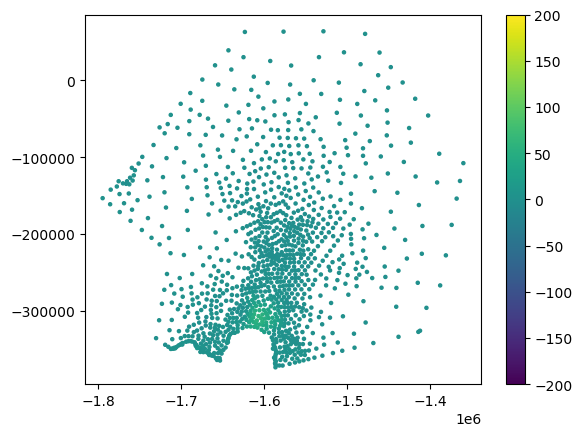

In [831]:
plt.scatter(x, y, c = torch.tensor(diff[100, :, 4])*12, s= 5, vmin = -200, vmax = 200)
plt.colorbar()

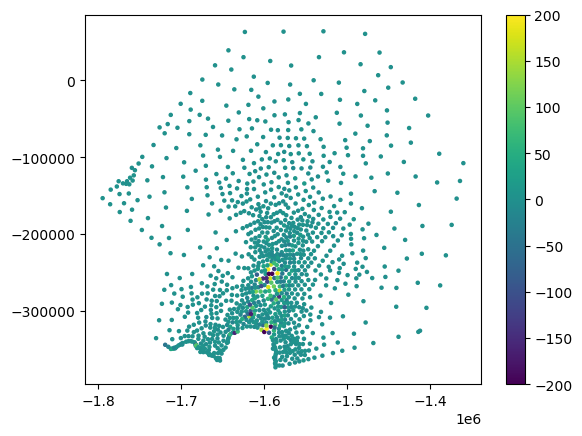

In [824]:
plt.scatter(x, y, c = torch.tensor(diff[0, :, 4])*12 + adv + div, s= 5, vmin = -200, vmax = 200)
plt.colorbar()

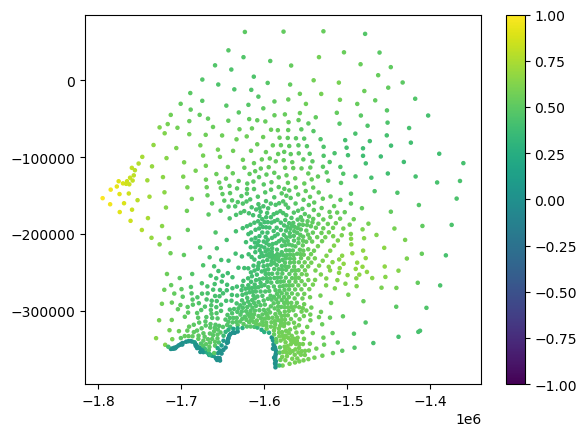

In [695]:
plt.scatter(x, y, c = smb1, s= 5, vmin = -1, vmax = 1)
plt.colorbar()

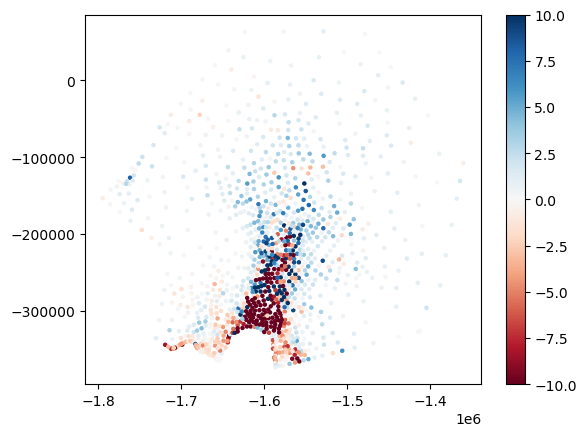

In [773]:
plt.scatter(x, y, c = adv+div, s= 5, vmin = -10, vmax = 10, cmap = "RdBu")
plt.colorbar()

In [612]:
smb[0] / 1112

array([1.57793150e-05, 2.11620204e-05, 0.00000000e+00, ...,
       6.89326719e-04, 3.57085029e-04, 0.00000000e+00])

In [614]:
elements.shape

(2085, 3)

In [618]:
edges[0].shape

torch.Size([12510])

In [506]:
dot

tensor([nan, nan, nan,  ..., nan, nan, nan])

In [476]:
ind = torch.where(g.edges()[0] == n)[0]

In [479]:
i.item()

1613

In [482]:
g.edges()[0][i.item()]

tensor(200)

In [42]:
test_rates

array([0.        , 0.2       , 0.40000001, 0.60000002])

In [43]:
rmse_all[model_type].shape

(6, 4, 240)

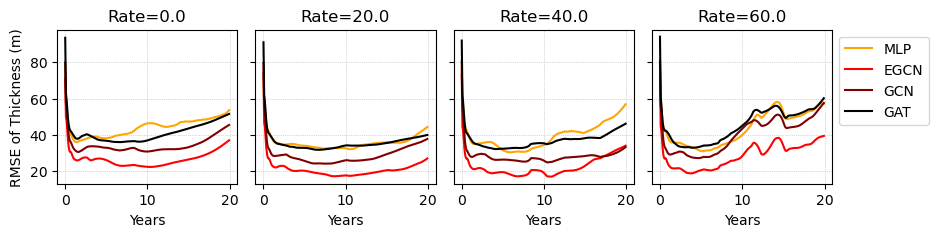

In [110]:
## Channel 3
channels = ["U velocity", "V velocity", "Thickness (m)", "Velocity (m/y)", "Floating"]
vmax = [1, 400, 400, 4000, 2000]
vmin = [0, -400, -400, 0, 0]
ls = ["-", "--", ":", "-.", None]
colors = ["orange", "red", "maroon", "k"]

c = 2
fig, ax = plt.subplots(1, len(test_rates), figsize = (len(test_rates)*2.5, 2), sharey = True)
plt.subplots_adjust(hspace=0.1, wspace=0.1)

for m, model_type in enumerate(model_types):
    for ci, i in enumerate(test_rates):
        ax[ci].plot(np.unique(years), rmse_all[model_type][c, ci, :], color = colors[m], label=f"{model_type.upper()}")
        ax[ci].grid(ls = ":", lw=0.5)
        ax[ci].set_xlabel("Years")
        ax[ci].set_title(f"Rate={np.round(i*100)}")
    
ax[0].set_ylabel("RMSE of " + channels[c])
plt.legend(bbox_to_anchor=(1,1))


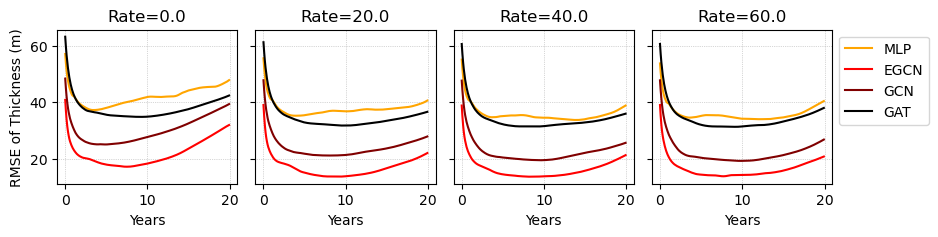

In [114]:
## Channel 6
scaling = [1, 5000, 5000, 5000, 4000, 3000]
year_list = [0, 3, 6, 9, 12, 15, 18]
vmax = [1, 5000, 5000, 5000, 2000, 3000]
vmin = [0, -5000, -5000, 0, 0, -3000]
verr = [0.01, 200, 200, 200, 100, 100]
cm = ["Spectral", "Spectral", "jet", "jet", "jet", "RdBu"]
channels = ["SMB", "U velocity", "V velocity", "Velocity (m/y)", "Thickness (m)", "Floating"]
colors = ["orange", "red", "maroon", "k"]

c = 4
fig, ax = plt.subplots(1, len(test_rates), figsize = (len(test_rates)*2.5, 2), sharey = True)
plt.subplots_adjust(hspace=0.1, wspace=0.1)

for m, model_type in enumerate(model_types):
    for ci, i in enumerate(test_rates):
        ax[ci].plot(np.unique(years), rmse_all[model_type][c, ci, :], color = colors[m], label=f"{model_type.upper()}")
        ax[ci].grid(ls = ":", lw=0.5)
        ax[ci].set_xlabel("Years")
        ax[ci].set_title(f"Rate={np.round(i*100)}")
    
ax[0].set_ylabel("RMSE of " + channels[c])
plt.legend(bbox_to_anchor=(1,1))


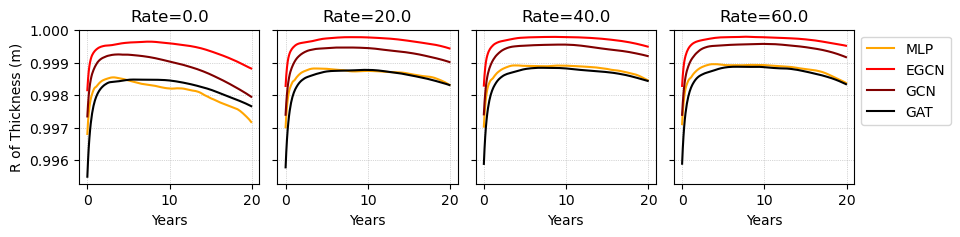

In [116]:
## Channel 6
scaling = [1, 5000, 5000, 5000, 4000, 3000]
year_list = [0, 3, 6, 9, 12, 15, 18]
vmax = [1, 5000, 5000, 5000, 2000, 3000]
vmin = [0, -5000, -5000, 0, 0, -3000]
verr = [0.01, 200, 200, 200, 100, 100]
cm = ["Spectral", "Spectral", "jet", "jet", "jet", "RdBu"]
channels = ["SMB", "U velocity", "V velocity", "Velocity (m/y)", "Thickness (m)", "Floating"]
colors = ["orange", "red", "maroon", "k"]

c = 4
fig, ax = plt.subplots(1, len(test_rates), figsize = (len(test_rates)*2.5, 2), sharey = True)
plt.subplots_adjust(hspace=0.1, wspace=0.1)

for m, model_type in enumerate(model_types):
    for ci, i in enumerate(test_rates):
        ax[ci].plot(np.unique(years), r_all[model_type][c, ci, :], color = colors[m], label=f"{model_type.upper()}")
        ax[ci].grid(ls = ":", lw=0.5)
        ax[ci].set_xlabel("Years")
        ax[ci].set_title(f"Rate={np.round(i*100)}")
    
ax[0].set_ylabel("R of " + channels[c])
plt.legend(bbox_to_anchor=(1,1))


0.17477473332768395 0.17954804050543952
0.44719925842114855 0.47229125528108507
0.8628234338192713 1.2761819911381556
1.5708759192909514 0.9087783798338875


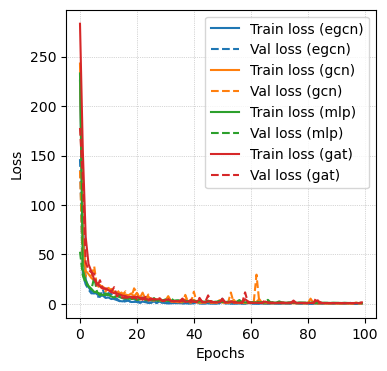

In [39]:
plt.subplots(1,1, figsize = (4,4))
year = 2022
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
for i, model in enumerate(["egcn", "gcn", "mlp", "gat"]):
    model_name = f"torch_dgl_{model}_lr0.01_nophy_ch6"
    with open(f'../model/history_{model_name}.pkl', 'rb') as file:
        history = pickle.load(file)

    plt.plot(history['loss'], color = colors[i], label = f"Train loss ({model})")
    plt.plot(history['val_loss'], color = colors[i], ls = "--", label = f"Val loss ({model})")

    print(history['loss'][-1], history['val_loss'][-1])
    # plt.xlim(0, 50)
    
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.yscale('log')
plt.grid(ls = ":", lw = 0.5)

In [220]:
history['loss']

[0.010884620338800319]

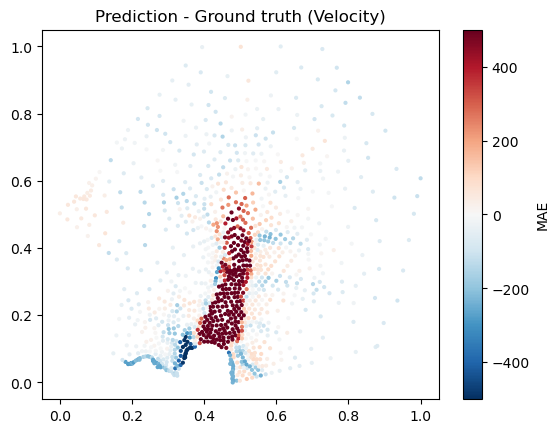

In [26]:
model_type = "gcn"
result_file = f"../results/test_torch_{model_type}_lr0.001_nophy_gpu.pkl"

with open(result_file, 'rb') as file:
    [rates, years, y_true0, y_pred0] = pickle.load(file)  

ind = 10
c = 3

channels = ["SMB", "U velocity", "V velocity", "Velocity", "Thickness"]
vmax = [1, 400, 400, 4000, 2000]
vmin = [0, -400, -400, 0, 0]

err = np.mean((y_pred0 - y_true0), axis=0)
plt.title(f"Prediction - Ground truth ({channels[c]})")
plt.scatter(xc, yc, c = err[:, c], s = 4, cmap = "RdBu_r", vmin = -500, vmax = 500)
plt.colorbar(label = "MAE")

In [32]:
y_true.shape

(1, 1112, 5)

IndexError: list index out of range

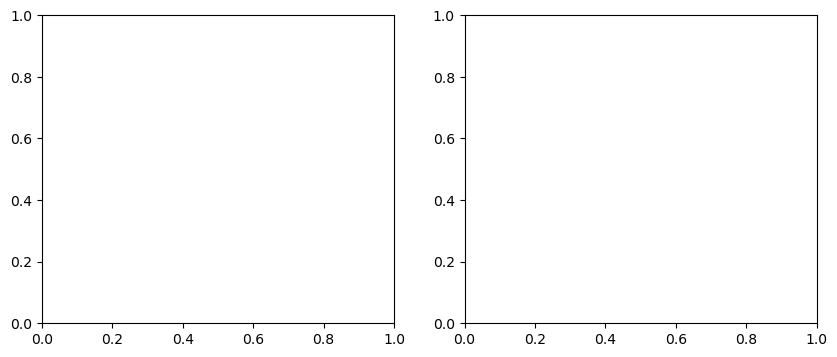

In [232]:
ind = 1200
c = 5
err = np.mean(abs(y_pred - y_true), axis=0)


fig, ax = plt.subplots(1,2, figsize = (10,4))
c1 = ax[0].scatter(xc, yc, c = y_true[0, :, c], s = 4, vmin = vmin[c], vmax = vmax[c], cmap = "Spectral")
ax[0].set_title(f"True {channels[c]} ({ind})")
fig.colorbar(c1, ax = ax[0])
c2 = ax[1].scatter(xc, yc, c = y_pred[0, :, c], s = 4, vmin = vmin[c], vmax = vmax[c], cmap = "Spectral")
ax[1].set_title(f"Predicted {channels[c]} ({ind})")
fig.colorbar(c1, ax = ax[1])

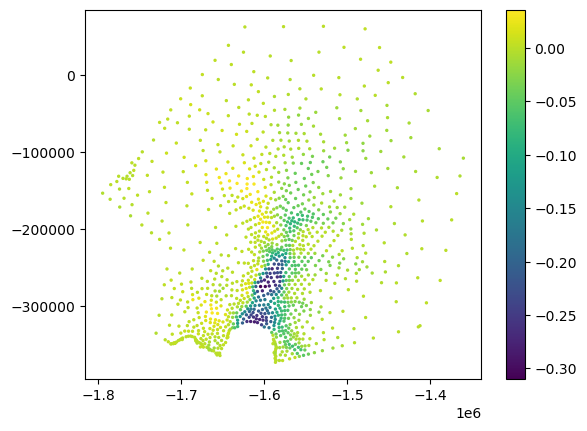

In [57]:
plt.scatter(xc, yc, c = vx[0]/5000, s = 2)
plt.colorbar()

205964106.30591267
205776418.05709606
205591376.5088661
205418323.7494367
205256813.25122318


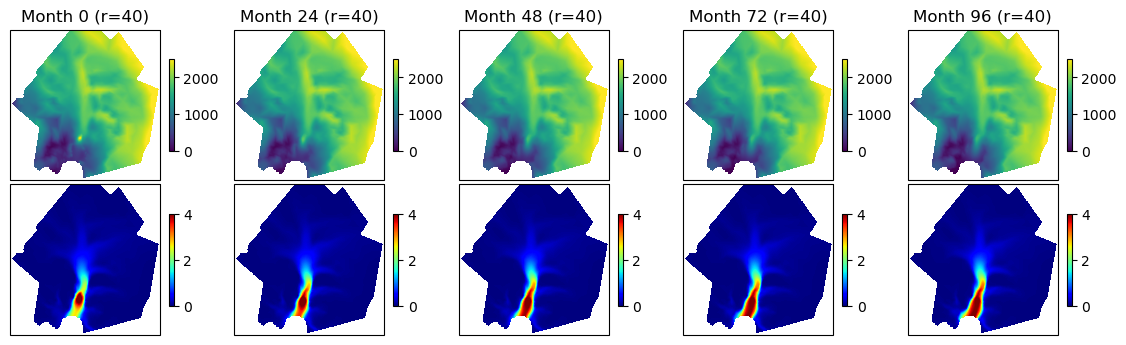

In [111]:
import scipy.io as sio
test = sio.loadmat('transient_y20_r40.mat')

fig, ax = plt.subplots(2, 5, figsize = (14,4), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)},)
plt.subplots_adjust(hspace=0.01)

t = 0

ice_vol40 = np.nansum(test['S'][0][0][3], axis = (1,2))
ice_vel40 = np.nanmean(test['S'][0][0][2], axis = (1,2))

for j in range(0, ax.shape[1]):
    t = 24*j
    for i in range(0, ax.shape[0]):    
        if i == 0:            
            data = test['S'][0][0][3]
            hmap = ax[i,j].imshow(data[t], origin = "lower", vmin = 0, vmax = 2500)
            fig.colorbar(hmap, ax = ax[i,j], shrink = 0.6)
            ax[i,j].set_title(f"Month {t} (r=40)")
            print(np.nansum(data[t]))
        if i == 1:            
            data = test['S'][0][0][2]
            vmap = ax[i,j].imshow(data[t]/1000, origin = "lower", vmin = 0, vmax = 4, cmap = "jet")
            fig.colorbar(vmap, ax = ax[i,j], shrink = 0.6)

205968118.00278923
205910434.94427702
205842919.99588054
205773103.6475761
205704447.55447897


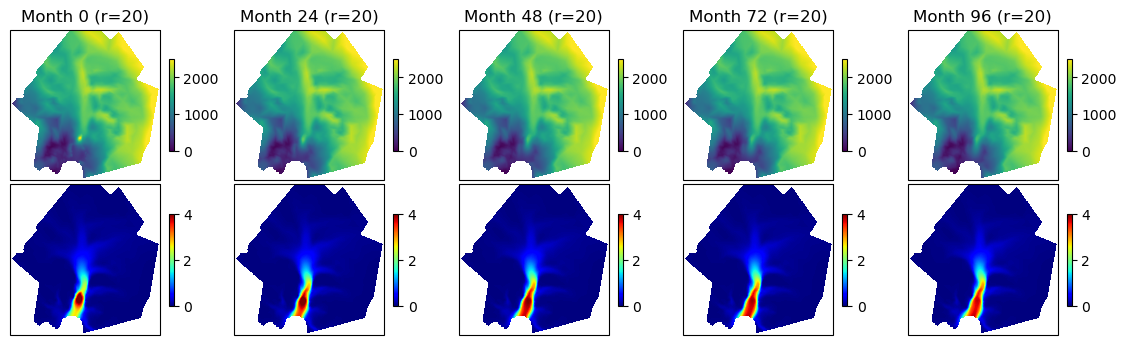

In [110]:
import scipy.io as sio
test = sio.loadmat('transient_y20_r20.mat')

fig, ax = plt.subplots(2, 5, figsize = (14,4), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)},)
plt.subplots_adjust(hspace=0.01)

t = 0

ice_vol20 = np.nansum(test['S'][0][0][3], axis = (1,2))
ice_vel20 = np.nanmean(test['S'][0][0][2], axis = (1,2))

for j in range(0, ax.shape[1]):
    t = 24*j
    for i in range(0, ax.shape[0]):    
        if i == 0:            
            data = test['S'][0][0][3]
            hmap = ax[i,j].imshow(data[t], origin = "lower", vmin = 0, vmax = 2500)
            fig.colorbar(hmap, ax = ax[i,j], shrink = 0.6)
            ax[i,j].set_title(f"Month {t} (r=20)")
            print(np.nansum(data[t]))
        if i == 1:            
            data = test['S'][0][0][2]
            vmap = ax[i,j].imshow(data[t]/1000, origin = "lower", vmin = 0, vmax = 4, cmap = "jet")
            fig.colorbar(vmap, ax = ax[i,j], shrink = 0.6)

205970126.9921308
205978459.7669149
205974605.06885847
205963737.60910466
205945981.8779817


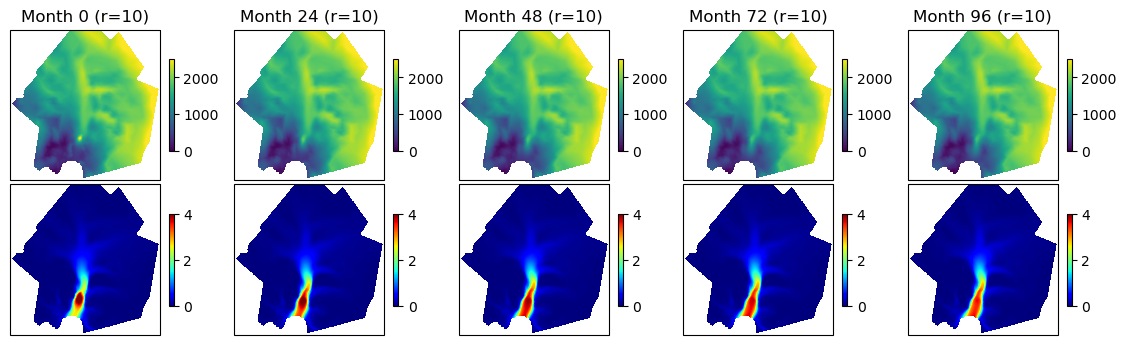

In [122]:
import scipy.io as sio
test = sio.loadmat('transient_y20_r10.mat')

fig, ax = plt.subplots(2, 5, figsize = (14,4), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)},)
plt.subplots_adjust(hspace=0.01)

t = 0

ice_vol10 = np.nansum(test['S'][0][0][3], axis = (1,2))
ice_vel10 = np.nanmean(test['S'][0][0][2], axis = (1,2))

for j in range(0, ax.shape[1]):
    t = 24*j
    for i in range(0, ax.shape[0]):    
        if i == 0:            
            data = test['S'][0][0][3]
            hmap = ax[i,j].imshow(data[t], origin = "lower", vmin = 0, vmax = 2500)
            fig.colorbar(hmap, ax = ax[i,j], shrink = 0.6)
            ax[i,j].set_title(f"Month {t} (r=10)")
            print(np.nansum(data[t]))
        if i == 1:            
            data = test['S'][0][0][2]
            vmap = ax[i,j].imshow(data[t]/1000, origin = "lower", vmin = 0, vmax = 4, cmap = "jet")
            fig.colorbar(vmap, ax = ax[i,j], shrink = 0.6)

205971131.48680156
206012976.71163708
206041501.56193674
206060713.93202695
206071883.7007757


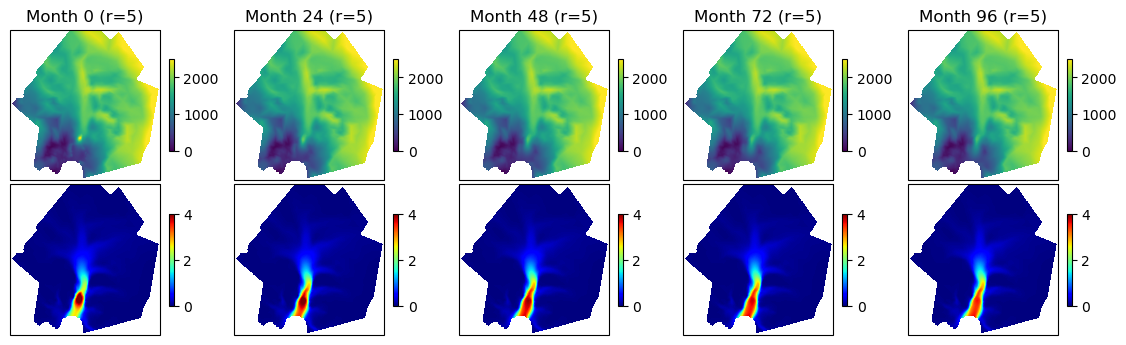

In [109]:
import scipy.io as sio
test = sio.loadmat('transient_y20_r5.mat')

fig, ax = plt.subplots(2, 5, figsize = (14,4), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude = 70)},)
plt.subplots_adjust(hspace=0.01)

t = 0

ice_vol05 = np.nansum(test['S'][0][0][3], axis = (1,2))
ice_vel05 = np.nanmean(test['S'][0][0][2], axis = (1,2))

for j in range(0, ax.shape[1]):
    t = 24*j
    for i in range(0, ax.shape[0]):    
        if i == 0:            
            data = test['S'][0][0][3]
            hmap = ax[i,j].imshow(data[t], origin = "lower", vmin = 0, vmax = 2500)
            fig.colorbar(hmap, ax = ax[i,j], shrink = 0.6)
            ax[i,j].set_title(f"Month {t} (r=5)")
            print(np.nansum(data[t]))
        if i == 1:            
            data = test['S'][0][0][2]
            vmap = ax[i,j].imshow(data[t]/1000, origin = "lower", vmin = 0, vmax = 4, cmap = "jet")
            fig.colorbar(vmap, ax = ax[i,j], shrink = 0.6)

Text(0, 0.5, 'Total ice volume ($km^3$)')

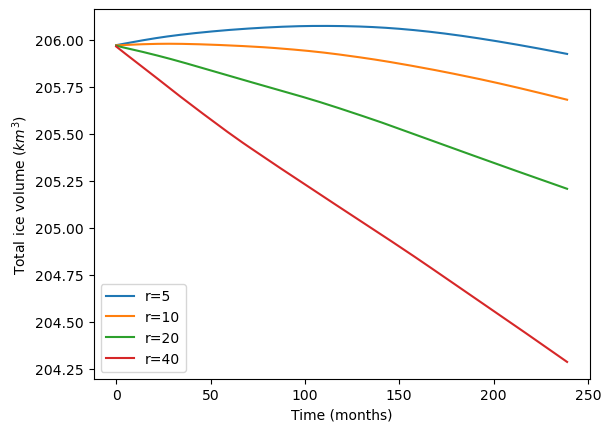

In [120]:
plt.plot(ice_vol05/1000000, label = "r=5")
plt.plot(ice_vol10/1000000, label = "r=10")
plt.plot(ice_vol20/1000000, label = "r=20")
plt.plot(ice_vol40/1000000, label = "r=40")
plt.legend()
plt.xlabel("Time (months)")
plt.ylabel("Total ice volume ($km^3$)")

Text(0, 0.5, 'Mean ice velocity (m/year)')

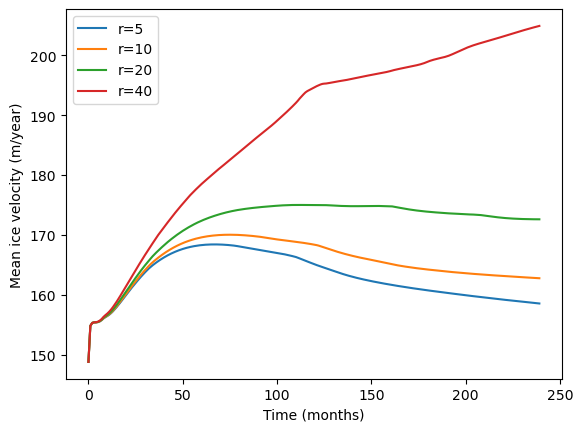

In [121]:
plt.plot(ice_vel05, label = "r=5")
plt.plot(ice_vel10, label = "r=10")
plt.plot(ice_vel20, label = "r=20")
plt.plot(ice_vel40, label = "r=40")
plt.legend()
plt.xlabel("Time (months)")
plt.ylabel("Mean ice velocity (m/year)")

In [4]:
import scipy.io as sio

filename = "D:\\ISSM\\transient_y20_r0.0.mat"
mat = sio.loadmat(filename)

In [6]:
mat['S'][0]

array([(array([[[nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               ...,
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan]],

              [[nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               ...,
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan]],

              [[nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               ...,
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan],
               [nan, nan, nan, ..., nan, nan, nan]]

In [ ]:
mat73.loadmat(full_path)